# Use skorch to do random Hyperparameter search for 5G RNA-seq data (single-task)
Given data that has been transformed into log-ratio TPMs, search the hyperparameter spaces of various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model

## *** Log(TPM) 

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


## Load 5G logTPM data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

log_data_filename = "data/XY_logTPM_opFilt.tsv"
XY_log = pd.read_csv(log_data_filename,sep='\t')

display(XY_log.head())

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.701712,5.159314,4.946232,4.544309,5.470820,5.489315,5.580793,5.425377,6.017577,5.002269,5.148210,5.063677
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.906680,5.431592,5.067489,4.241518,5.897951,6.022614,6.305779,5.935676,6.629400,5.448133,5.385163,5.449226
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,5.085045,4.772192,4.208764,4.205855,4.821135,4.878684,5.067555,4.849435,5.487238,4.416274,4.367689,4.534353
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,5.604311,5.064503,4.983838,4.084119,5.639215,5.606737,5.604730,5.671486,6.282482,5.381454,5.098383,5.404872
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.766245,4.767261,3.688497,3.422344,4.763636,4.687598,4.858654,4.698693,4.286940,4.525268,5.031830,5.103249


In [5]:
loc2seq = dict([(x,z) for (x,z) in XY_log[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


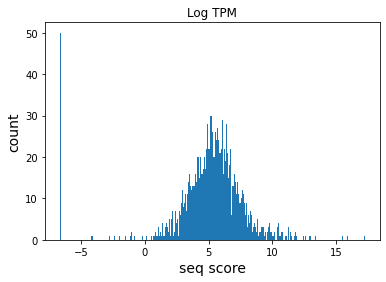

In [6]:
# Log TPM - highCu column
plt.hist(XY_log['highCu'].values,bins=500)
plt.title("score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

In [7]:
for df in [XY_log]:
    df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
    df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

## Load 5G seqs into data loaders

In [9]:
# LOG
log_full_train_df,log_test_df = tu.quick_split(XY_log)
log_train_df, log_val_df = tu.quick_split(log_full_train_df)

print(log_full_train_df.shape)
print(log_test_df.shape)
print(log_train_df.shape)
print(log_val_df.shape)

assert(log_train_df.shape[0] + log_val_df.shape[0] == log_full_train_df.shape[0])

(1763, 18)
(441, 18)
(1410, 19)
(353, 19)


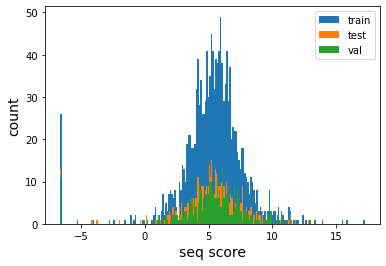

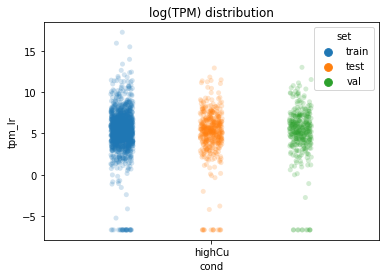

In [10]:
# plot_train_test_hist(log_full_train_df, log_test_df,score_col='highCu',bins=200)
# plot_train_test_hist(log_train_df, log_val_df,score_col='highCu',bins=200)

# split the genes, show dist of logTPM of HighCu column
plot_train_test_hist(log_train_df, log_test_df, val_df=log_val_df,score_col='highCu',bins=200)
view_train_test_dist(log_train_df, log_test_df,["highCu"],"log(TPM)",val_df=log_val_df)

In [11]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [12]:
# Dfs for the full train/test split
log_final_dls = tu.build_dataloaders_single(
    log_full_train_df, 
    log_test_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu')

# Dfs from further spliting train into train and val
log_dls = tu.build_dataloaders_single(
    log_train_df, 
    log_val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu'
)

log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
log_ohe_train_dl,log_ohe_val_dl = log_dls['ohe']

In [13]:
len(log_kmer6_train_dl.dataset.kmers)

4096

In [14]:
log_ohe_train_dl

## run model 

E:300 | train loss:2.710 | val loss: 8.542:   6%|▌         | 299/5000 [00:14<03:49, 20.44it/s] 

EarlyStopping counter: 125 out of 500


E:425 | train loss:1.953 | val loss: 8.689:   8%|▊         | 425/5000 [00:21<03:45, 20.27it/s] 

EarlyStopping counter: 250 out of 500


E:550 | train loss:1.275 | val loss: 11.036:  11%|█         | 551/5000 [00:27<03:37, 20.42it/s]

EarlyStopping counter: 375 out of 500


E:779 | train loss:0.767 | val loss: 8.057:  16%|█▌        | 778/5000 [00:38<03:29, 20.13it/s] 

EarlyStopping counter: 125 out of 500


E:904 | train loss:0.608 | val loss: 8.147:  18%|█▊        | 903/5000 [00:44<03:23, 20.09it/s] 

EarlyStopping counter: 250 out of 500


E:1773 | train loss:0.468 | val loss: 7.480:  35%|███▌      | 1772/5000 [01:28<02:42, 19.82it/s]

EarlyStopping counter: 125 out of 500


E:1898 | train loss:0.468 | val loss: 7.505:  38%|███▊      | 1899/5000 [01:34<02:34, 20.05it/s]

EarlyStopping counter: 250 out of 500


E:2203 | train loss:0.396 | val loss: 7.184:  44%|████▍     | 2203/5000 [01:49<02:21, 19.75it/s]

EarlyStopping counter: 125 out of 500


E:2413 | train loss:0.385 | val loss: 7.160:  48%|████▊     | 2414/5000 [02:00<02:09, 19.92it/s]

EarlyStopping counter: 125 out of 500


E:2538 | train loss:0.369 | val loss: 7.333:  51%|█████     | 2538/5000 [02:06<02:04, 19.83it/s]

EarlyStopping counter: 250 out of 500


E:2663 | train loss:0.381 | val loss: 6.982:  53%|█████▎    | 2663/5000 [02:13<01:57, 19.81it/s]

EarlyStopping counter: 375 out of 500


E:2785 | train loss:0.347 | val loss: 7.063:  56%|█████▌    | 2785/5000 [02:19<01:50, 19.98it/s]


EarlyStopping counter: 500 out of 500
Early stopping


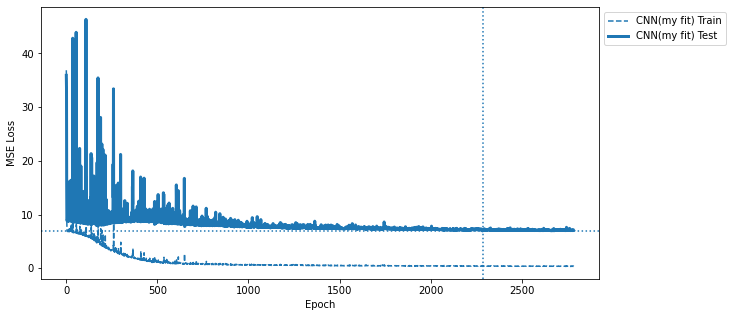

In [18]:
seq_len = len(log_train_df['upstream_region'].values[0])
model_cnn = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
)
model_cnn.to(DEVICE)

# train_losses_cnn, \
# test_losses_cnn = run_model(
#     log_ohe_train_dl, 
#     log_ohe_val_dl, 
#     model_cnn, 
#     lr=0.001,#0.0001,
#     epochs=100,
# )

loss_func = torch.nn.MSELoss() 

train_losses_cnn, \
val_losses_cnn, \
epoch_stop, \
best_val_score = tu.run_model(
    log_ohe_train_dl,
    log_ohe_val_dl, 
    model_cnn, 
    loss_func, 
    DEVICE,
    lr=0.001, 
    epochs=5000, 
    opt=None,
    patience=500)

# to plot loss
cnn_data_label = [((train_losses_cnn,val_losses_cnn),'CNN(my fit)',epoch_stop,best_val_score)]
tu.quick_loss_plot(cnn_data_label)

Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


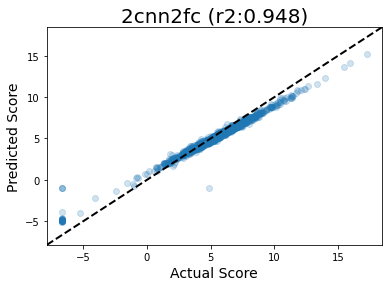

Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


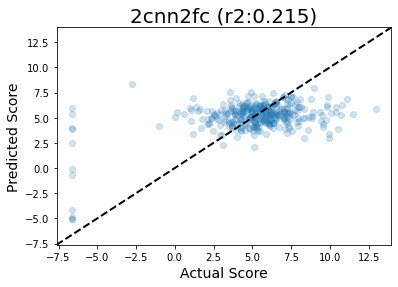

Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


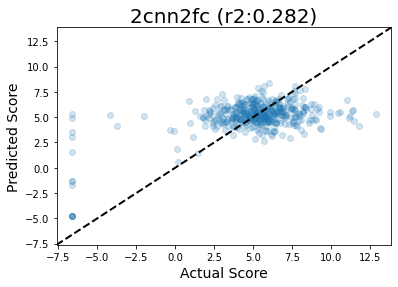

In [20]:
models = [
    ("2cnn2fc",model_cnn)
]

train_dfs = tu.parity_pred_loci(models,log_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
val_dfs = tu.parity_pred_loci(models,log_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
test_dfs  = tu.parity_pred_loci(models,log_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


## try fitting with skorch instead

In [22]:
def make_skorch_dfs(df,seq_col='seq',target_col='score'):
    '''
    Make basic X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    # had to unsqueeze here or else errors later
    
    return ohe_seqs.float(), labels.float()

In [23]:
X, y = make_skorch_dfs(log_full_train_df, seq_col='upstream_region',target_col='highCu')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [24]:
from skorch.callbacks import EarlyStopping,Checkpoint,LoadInitState

In [48]:
# Make a skorch regressor object
patience= 500
net_regr = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=1,
    max_epochs=5000,
    lr=0.001, # this is passed to the skorch fit, i think
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[EarlyStopping(patience=patience),Checkpoint(dirname='testcheck')]
)

In [49]:
# Just call fit!
net_regr.fit(X, y)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       29.5976       17.2151     +  0.0789
      2        9.3181       11.5839     +  0.0788
      3        7.6932       11.6101        0.0802
      4        7.6922       11.0863     +  0.0664
      5        7.6361       11.6947        0.0661
      6        7.6555       10.9969     +  0.0666
      7        7.6019       11.1316        0.0608
      8        7.5900       10.8508     +  0.0606
      9        7.5706       11.1595        0.0602
     10        7.6024       10.9887        0.0572
     11        7.5457       10.7897     +  0.0583
     12        7.5062       11.0450        0.0637
     13        7.5031       10.5972     +  0.0566
     14        7.4483       10.4520     +  0.0561
     15        7.4481       10.1970     +  0.0560
     16        7.4270        9.8129     +  0.0568
     17        7.3719        9.7207     +  0.0574
     18        7.3579        9.7704        0.0579


    140        4.1531        6.9776        0.0577
    141        4.0829        6.4011        0.0565
    142        4.0396        6.3967        0.0562
    143        4.0485        7.3621        0.0559
    144        4.4466        6.9246        0.0560
    145        3.9857        6.5039        0.0559
    146        3.9574        6.5865        0.0557
    147        3.9825        7.1090        0.0558
    148        3.9391        6.5032        0.0559
    149        3.8649        6.6239        0.0568
    150        3.9111        6.7198        0.0569
    151        3.7863        6.5249        0.0564
    152        3.7194        6.9365        0.0560
    153        4.1450        7.0142        0.0568
    154        3.8296        6.5825        0.0563
    155        3.7628        6.4631        0.0569
    156        3.8899        6.8431        0.0564
    157        3.6927        6.7209        0.0557
    158        3.7021        8.8138        0.0557
    159        3.9783        8.4961        0.0561


    296        2.0373        6.9392        0.0562
    297        1.8504        6.7590        0.0563
    298        1.8203        6.8621        0.0563
    299        1.7845        9.1464        0.0558
    300        2.0096        7.3129        0.0555
    301        1.8377        7.9594        0.0555
    302        2.1210        8.3320        0.0553
    303        1.9030        7.0832        0.0556
    304        1.9084        7.9583        0.0554
    305        2.1293       11.5824        0.0555
    306        2.1951        6.7769        0.0553
    307        1.8114        6.7816        0.0561
    308        1.6361        8.6996        0.0565
    309        1.8162        9.2994        0.0560
    310        2.4172        8.2343        0.0561
    311        1.7737        6.8526        0.0566
    312        1.6776        8.2362        0.0563
    313        1.7832        7.4114        0.0562
    314        1.8149        9.2031        0.0565
    315        1.8988        6.6955        0.0566


    455        1.1227        6.4739        0.0563
    456        0.8959        9.3608        0.0564
    457        1.1081        6.2100        0.0560
    458        0.8542        6.6780        0.0567
    459        0.8502        6.3122        0.0571
    460        0.7826        6.4572        0.0562
    461        0.8375        6.2809        0.0569
    462        0.8545        6.5608        0.0558
    463        0.8351        6.3125        0.0560
    464        0.7972        6.3560        0.0559
    465        0.8293        6.3583        0.0559
    466        0.8818        6.6524        0.0564
    467        0.8795        7.1026        0.0567
    468        0.8283        6.6184        0.0568
    469        0.8211        6.2662        0.0584
    470        0.8148        7.6809        0.0575
    471        1.1490        6.6461        0.0564
    472        0.8509        6.6611        0.0562
    473        0.9257        6.7391        0.0567
    474        0.8380        6.2587        0.0564


    616        0.8289        7.3991        0.0562
    617        0.6940        5.9243        0.0561
    618        0.6916        6.5201        0.0560
    619        0.6365        6.4980        0.0561
    620        0.6653        6.0010        0.0561
    621        0.6762        5.8708     +  0.0566
    622        0.6314        6.7384        0.0567
    623        0.6798        6.2368        0.0560
    624        0.6566        5.9734        0.0570
    625        0.6032        5.8853        0.0567
    626        0.6598        6.0661        0.0566
    627        0.6744        6.2199        0.0561
    628        0.6359        5.9476        0.0569
    629        0.6683        6.3409        0.0569
    630        0.6768        6.0644        0.0559
    631        0.6391        6.0865        0.0568
    632        0.6232        6.9660        0.0567
    633        0.6817        6.2440        0.0566
    634        0.6318        6.3627        0.0566
    635        0.7762        6.2174        0.0567


    778        0.6137        5.7697        0.0576
    779        0.5693        6.5021        0.0579
    780        0.5910        5.7434     +  0.0581
    781        0.5605        5.7411     +  0.0580
    782        0.5937        6.2684        0.0573
    783        0.5478        7.3215        0.0559
    784        0.6237        5.7986        0.0564
    785        0.5843        5.8220        0.0562
    786        0.5698        6.0411        0.0562
    787        0.5512        6.3026        0.0561
    788        0.5645        6.1841        0.0560
    789        0.6904        8.0606        0.0561
    790        0.7026        5.8595        0.0559
    791        0.5838        5.8252        0.0558
    792        0.5758        6.0947        0.0563
    793        0.5232        6.4981        0.0562
    794        0.5857        6.0050        0.0559
    795        0.5302        5.7752        0.0561
    796        0.5735        5.8996        0.0561
    797        0.5199        5.8290        0.0563


    939        0.4977        6.0076        0.0570
    940        0.4885        6.1238        0.0571
    941        0.5172        5.6915        0.0572
    942        0.4724        6.4864        0.0583
    943        0.5200        5.6641        0.0576
    944        0.4688        5.7264        0.0582
    945        0.4934        6.6488        0.0585
    946        0.5584        5.8630        0.0570
    947        0.4472        6.5650        0.0572
    948        0.5615        5.8118        0.0571
    949        0.5092        5.6727        0.0578
    950        0.4417        5.9753        0.0574
    951        0.5318        6.1719        0.0571
    952        0.5048        5.6107     +  0.0570
    953        0.4717        5.7070        0.0590
    954        0.4386        5.6825        0.0566
    955        0.4904        6.0619        0.0570
    956        0.4584        6.1074        0.0571
    957        0.4768        5.8526        0.0572
    958        0.5335        6.2794        0.0572


   1100        0.4270        5.4851     +  0.0567
   1101        0.4654        5.9580        0.0582
   1102        0.4523        5.5009        0.0573
   1103        0.4694        6.7120        0.0569
   1104        0.4936        5.4927        0.0563
   1105        0.4678        5.6192        0.0561
   1106        0.4547        6.0359        0.0561
   1107        0.4684        5.9515        0.0563
   1108        0.4731        5.5078        0.0574
   1109        0.4272        5.4710     +  0.0559
   1110        0.4523        6.0489        0.0579
   1111        0.4423        5.6590        0.0564
   1112        0.4265        5.5674        0.0567
   1113        0.4486        5.6371        0.0567
   1114        0.4371        5.7087        0.0567
   1115        0.4113        5.5636        0.0562
   1116        0.4173        5.4551     +  0.0567
   1117        0.4513        5.5648        0.0577
   1118        0.4110        6.1552        0.0566
   1119        0.4642        5.4790        0.0563


   1261        0.4126        5.9061        0.0570
   1262        0.4114        5.4241        0.0572
   1263        0.4105        5.6553        0.0569
   1264        0.3700        5.4534        0.0584
   1265        0.3847        5.3921        0.0576
   1266        0.3992        5.8268        0.0567
   1267        0.4067        5.6202        0.0566
   1268        0.4078        5.8201        0.0563
   1269        0.3971        5.3782     +  0.0563
   1270        0.3736        5.4144        0.0603
   1271        0.3878        5.5169        0.0593
   1272        0.3807        5.6411        0.0568
   1273        0.3989        5.4627        0.0566
   1274        0.3862        5.6889        0.0566
   1275        0.4459        5.3804        0.0575
   1276        0.3813        5.9197        0.0571
   1277        0.4150        5.5128        0.0571
   1278        0.4800        5.8287        0.0565
   1279        0.4018        5.3940        0.0573
   1280        0.4245        5.5185        0.0574


   1424        0.3680        5.6167        0.0569
   1425        0.3563        5.3365        0.0572
   1426        0.3668        5.7280        0.0573
   1427        0.3799        5.3548        0.0582
   1428        0.3638        5.3185        0.0565
   1429        0.3749        5.3149     +  0.0560
   1430        0.3604        5.6506        0.0605
   1431        0.3626        5.4244        0.0563
   1432        0.3783        5.4483        0.0560
   1433        0.3859        5.3330        0.0569
   1434        0.3709        5.4908        0.0571
   1435        0.3619        5.6965        0.0562
   1436        0.3919        5.3239        0.0564
   1437        0.3688        5.6740        0.0569
   1438        0.3804        5.3016     +  0.0566
   1439        0.3912        5.6988        0.0580
   1440        0.3828        5.4172        0.0563
   1441        0.3898        5.3554        0.0562
   1442        0.3795        5.4132        0.0575
   1443        0.3726        5.4492        0.0566


   1587        0.3719        5.4620        0.0568
   1588        0.3330        5.2583     +  0.0579
   1589        0.3458        5.5527        0.0586
   1590        0.3514        5.2793        0.0564
   1591        0.3406        5.3687        0.0570
   1592        0.3722        5.3540        0.0575
   1593        0.3491        5.3640        0.0571
   1594        0.3359        5.3304        0.0569
   1595        0.3439        5.5962        0.0575
   1596        0.3589        5.3016        0.0586
   1597        0.3551        5.3175        0.0568
   1598        0.3438        5.4333        0.0573
   1599        0.3484        5.3673        0.0578
   1600        0.3381        5.4288        0.0568
   1601        0.3534        5.3412        0.0577
   1602        0.3728        5.4253        0.0567
   1603        0.3341        5.5585        0.0569
   1604        0.3334        5.3002        0.0573
   1605        0.3520        5.3335        0.0566
   1606        0.3871        5.5979        0.0571


   1750        0.3500        5.3408        0.0574
   1751        0.3380        5.2919        0.0565
   1752        0.3322        5.2454        0.0569
   1753        0.3181        5.2138     +  0.0576
   1754        0.3427        5.6305        0.0594
   1755        0.3521        5.2383        0.0566
   1756        0.3512        5.2955        0.0581
   1757        0.3368        5.2291        0.0575
   1758        0.3095        5.2949        0.0569
   1759        0.3592        5.7635        0.0571
   1760        0.3699        5.3251        0.0570
   1761        0.3047        5.2376        0.0572
   1762        0.3406        5.5876        0.0573
   1763        0.3490        5.3545        0.0568
   1764        0.3370        5.2256        0.0578
   1765        0.3288        5.2353        0.0569
   1766        0.3512        5.2653        0.0570
   1767        0.3199        5.7220        0.0578
   1768        0.3428        5.2397        0.0566
   1769        0.3273        5.4548        0.0572


   1913        0.3478        5.3504        0.0571
   1914        0.3051        5.2065        0.0571
   1915        0.3543        5.1978        0.0573
   1916        0.3602        5.2605        0.0569
   1917        0.3397        5.3763        0.0572
   1918        0.3178        5.2740        0.0572
   1919        0.3277        5.2002        0.0571
   1920        0.3171        5.6739        0.0576
   1921        0.3654        5.4210        0.0576
   1922        0.3268        5.2260        0.0566
   1923        0.3264        5.3584        0.0571
   1924        0.3143        5.2899        0.0576
   1925        0.3109        5.3409        0.0582
   1926        0.3247        5.2348        0.0566
   1927        0.3396        5.4508        0.0572
   1928        0.3416        5.1992        0.0567
   1929        0.3221        5.6709        0.0570
   1930        0.3355        5.2555        0.0567
   1931        0.3779        5.2025        0.0563
   1932        0.3346        5.1855        0.0573


   2077        0.3115        5.2930        0.0572
   2078        0.2939        5.2105        0.0580
   2079        0.3008        5.3598        0.0572
   2080        0.2914        5.5343        0.0570
   2081        0.3255        5.1913        0.0572
   2082        0.3081        5.1799        0.0588
   2083        0.3637        5.2843        0.0574
   2084        0.2760        5.3167        0.0573
   2085        0.3020        5.2567        0.0586
   2086        0.3079        5.1677        0.0582
   2087        0.3306        5.2126        0.0570
   2088        0.2933        5.4014        0.0574
   2089        0.3203        5.2027        0.0571
   2090        0.3179        5.5868        0.0571
   2091        0.3103        5.1749        0.0567
   2092        0.3142        5.2288        0.0572
   2093        0.2993        5.2204        0.0571
   2094        0.2853        5.3495        0.0573
   2095        0.3240        5.2054        0.0583
   2096        0.2975        5.1625        0.0590


   2240        0.2886        5.1391        0.0572
   2241        0.3139        5.3970        0.0572
   2242        0.3301        5.1393        0.0573
   2243        0.3070        5.1796        0.0566
   2244        0.2875        5.2362        0.0572
   2245        0.2970        5.2376        0.0585
   2246        0.2809        5.3476        0.0587
   2247        0.3240        5.1365        0.0577
   2248        0.3026        5.3864        0.0591
   2249        0.3070        5.1171     +  0.0573
   2250        0.2988        5.2527        0.0597
   2251        0.3153        5.2072        0.0605
   2252        0.3214        5.1340        0.0594
   2253        0.2956        5.4302        0.0578
   2254        0.3070        5.1793        0.0573
   2255        0.2957        5.1180        0.0576
   2256        0.3063        5.2793        0.0572
   2257        0.3022        5.1972        0.0575
   2258        0.2788        5.1888        0.0564
   2259        0.2844        5.1440        0.0571


   2404        0.2789        5.3758        0.0585
   2405        0.3042        5.1388        0.0590
   2406        0.2768        5.1212        0.0586
   2407        0.3004        5.1632        0.0577
   2408        0.2952        5.3840        0.0584
   2409        0.3214        5.1395        0.0574
   2410        0.2637        5.1280        0.0580
   2411        0.2863        5.1784        0.0582
   2412        0.2807        5.1937        0.0583
   2413        0.3009        5.2567        0.0582
   2414        0.2740        5.1794        0.0594
   2415        0.2687        5.2850        0.0581
   2416        0.2919        5.1311        0.0580
   2417        0.2795        5.1240        0.0577
   2418        0.2734        5.1437        0.0584
   2419        0.2948        5.1467        0.0584
   2420        0.2777        5.4270        0.0587
   2421        0.3025        5.1566        0.0602
   2422        0.2803        5.2383        0.0605
   2423        0.2634        5.1314        0.0591


   2567        0.2781        5.1140        0.0600
   2568        0.2700        5.2698        0.0603
   2569        0.2848        5.1670        0.0576
   2570        0.2782        5.1203        0.0580
   2571        0.2792        5.1955        0.0578
   2572        0.2789        5.1786        0.0573
   2573        0.2747        5.1298        0.0573
   2574        0.3025        5.1047        0.0575
   2575        0.2906        5.4488        0.0581
   2576        0.2955        5.1956        0.0576
   2577        0.2875        5.2350        0.0580
   2578        0.2566        5.0990        0.0579
   2579        0.2743        5.1901        0.0586
   2580        0.2654        5.1082        0.0578
   2581        0.2736        5.1014        0.0585
   2582        0.2988        5.1078        0.0575
   2583        0.2971        5.2141        0.0573
   2584        0.2744        5.2352        0.0580
   2585        0.2726        5.2214        0.0576
   2586        0.2955        5.1082        0.0573


   2731        0.2727        5.0956        0.0577
   2732        0.2743        5.0871        0.0573
   2733        0.2775        5.1656        0.0578
   2734        0.2785        5.1885        0.0580
   2735        0.2508        5.0712        0.0574
   2736        0.2621        5.5996        0.0581
   2737        0.3171        5.0730        0.0580
   2738        0.2602        5.0582     +  0.0573
   2739        0.2747        5.0680        0.0623
   2740        0.2540        5.0694        0.0595
   2741        0.2669        5.0814        0.0592
   2742        0.2733        5.2815        0.0591
   2743        0.2724        5.0945        0.0588
   2744        0.2703        5.1578        0.0589
   2745        0.2969        5.0696        0.0582
   2746        0.3057        5.3010        0.0574
   2747        0.3005        5.0696        0.0575
   2748        0.2755        5.0914        0.0596
   2749        0.2730        5.1383        0.0575
   2750        0.2529        5.1349        0.0573


   2894        0.2767        5.1102        0.0587
   2895        0.2979        5.1568        0.0581
   2896        0.2673        5.1222        0.0585
   2897        0.2891        5.2457        0.0582
   2898        0.2527        5.0580        0.0596
   2899        0.2601        5.0965        0.0570
   2900        0.2617        5.0858        0.0583
   2901        0.2837        5.0901        0.0594
   2902        0.2536        5.1393        0.0608
   2903        0.2455        5.2980        0.0595
   2904        0.2844        5.0681        0.0576
   2905        0.2769        5.1587        0.0580
   2906        0.2558        5.0645        0.0580
   2907        0.2830        5.2521        0.0570
   2908        0.2790        5.0717        0.0579
   2909        0.2949        5.2046        0.0584
   2910        0.2666        5.0776        0.0588
   2911        0.2781        5.0812        0.0589
   2912        0.2524        5.1543        0.0574
   2913        0.2851        5.1113        0.0575


   3058        0.2565        5.2068        0.0588
   3059        0.2637        5.0510        0.0573
   3060        0.2444        5.1150        0.0584
   3061        0.2677        5.0588        0.0576
   3062        0.2610        5.2469        0.0586
   3063        0.2586        5.1249        0.0574
   3064        0.2456        5.1390        0.0574
   3065        0.2435        5.0473        0.0576
   3066        0.2785        5.0639        0.0576
   3067        0.2784        5.2775        0.0573
   3068        0.2711        5.0462        0.0571
   3069        0.2733        5.0453        0.0584
   3070        0.2498        5.0518        0.0578
   3071        0.2556        5.2725        0.0581
   3072        0.2982        5.1354        0.0580
   3073        0.2727        5.0712        0.0583
   3074        0.2703        5.0902        0.0576
   3075        0.2564        5.1503        0.0582
   3076        0.2560        5.1502        0.0576
   3077        0.2588        5.0474        0.0576


   3222        0.2561        5.0283     +  0.0586
   3223        0.2623        5.0781        0.0592
   3224        0.2454        5.0660        0.0576
   3225        0.2570        5.0467        0.0578
   3226        0.2743        5.0424        0.0583
   3227        0.2598        5.0907        0.0585
   3228        0.2487        5.0578        0.0582
   3229        0.2510        5.0306        0.0578
   3230        0.2755        5.0623        0.0579
   3231        0.2712        5.1108        0.0579
   3232        0.2498        5.1144        0.0573
   3233        0.2530        5.1814        0.0577
   3234        0.2682        5.0655        0.0583
   3235        0.2647        5.0733        0.0572
   3236        0.2509        5.0248     +  0.0579
   3237        0.2538        5.0463        0.0595
   3238        0.2378        5.1481        0.0576
   3239        0.2703        5.2133        0.0579
   3240        0.2524        5.0405        0.0575
   3241        0.2372        5.0359        0.0573


   3385        0.2774        5.0369        0.0580
   3386        0.2520        5.0579        0.0577
   3387        0.2579        5.1288        0.0587
   3388        0.2434        5.1430        0.0592
   3389        0.2348        5.0356        0.0581
   3390        0.2409        5.1452        0.0600
   3391        0.2349        5.0046     +  0.0583
   3392        0.2532        5.1660        0.0589
   3393        0.2427        5.0149        0.0588
   3394        0.2506        5.0277        0.0580
   3395        0.2500        5.0345        0.0584
   3396        0.2463        5.3653        0.0596
   3397        0.2981        5.0380        0.0590
   3398        0.2457        5.0970        0.0581
   3399        0.2708        5.0992        0.0583
   3400        0.2316        5.0181        0.0585
   3401        0.2518        5.0174        0.0576
   3402        0.2689        5.1534        0.0586
   3403        0.2656        5.0086        0.0585
   3404        0.2473        5.0335        0.0577


   3549        0.2689        5.0310        0.0578
   3550        0.2570        5.0975        0.0579
   3551        0.2474        5.0472        0.0574
   3552        0.2319        5.0269        0.0584
   3553        0.2591        5.0156        0.0573
   3554        0.2489        5.0637        0.0589
   3555        0.2492        5.0892        0.0581
   3556        0.2389        5.0245        0.0594
   3557        0.2577        5.0259        0.0582
   3558        0.2346        5.1904        0.0580
   3559        0.2683        5.0359        0.0578
   3560        0.2591        5.0119        0.0580
   3561        0.2628        5.0727        0.0583
   3562        0.2441        5.0331        0.0584
   3563        0.2496        5.0681        0.0578
   3564        0.2466        5.0303        0.0577
   3565        0.2348        5.1244        0.0580
   3566        0.2238        5.0774        0.0574
   3567        0.2424        5.0554        0.0585
   3568        0.2491        5.0244        0.0580


   3713        0.2245        5.0489        0.0590
   3714        0.2222        5.0963        0.0578
   3715        0.2648        5.0334        0.0580
   3716        0.2492        5.0109        0.0582
   3717        0.2372        5.1025        0.0576
   3718        0.2414        5.0089        0.0580
   3719        0.2514        5.0792        0.0577
   3720        0.2445        5.0529        0.0588
   3721        0.2359        5.0009        0.0581
   3722        0.2410        5.0164        0.0576
   3723        0.2395        5.0138        0.0587
   3724        0.2571        4.9945     +  0.0588
   3725        0.2386        5.0152        0.0586
   3726        0.2542        5.0484        0.0578
   3727        0.2442        5.0403        0.0575
   3728        0.2477        4.9985        0.0587
   3729        0.2486        5.0481        0.0588
   3730        0.2483        5.0089        0.0594
   3731        0.2414        4.9918     +  0.0584
   3732        0.2391        5.0449        0.0599


   3876        0.2539        5.0218        0.0581
   3877        0.2373        5.0022        0.0581
   3878        0.2187        4.9882        0.0584
   3879        0.2223        4.9911        0.0603
   3880        0.2279        5.1797        0.0586
   3881        0.2419        5.0139        0.0576
   3882        0.2331        5.0053        0.0587
   3883        0.2542        5.0459        0.0592
   3884        0.2575        5.0138        0.0591
   3885        0.2292        5.0233        0.0586
   3886        0.2269        5.0892        0.0584
   3887        0.2622        5.0467        0.0589
   3888        0.2267        5.0137        0.0580
   3889        0.2232        5.0639        0.0589
   3890        0.2315        5.0141        0.0581
   3891        0.2358        5.1002        0.0592
   3892        0.2261        5.0021        0.0591
   3893        0.2608        4.9976        0.0588
   3894        0.2196        4.9930        0.0583
   3895        0.2469        5.1163        0.0594


   4040        0.2415        5.0490        0.0604
   4041        0.2370        4.9893        0.0600
   4042        0.2336        5.0329        0.0609
   4043        0.2343        5.0349        0.0601
   4044        0.2417        5.0047        0.0593
   4045        0.2264        4.9991        0.0607
   4046        0.2194        4.9855        0.0588
   4047        0.2171        4.9859        0.0590
   4048        0.2235        5.0043        0.0593
   4049        0.2560        5.0793        0.0581
   4050        0.2388        4.9805        0.0595
   4051        0.2364        5.0812        0.0597
   4052        0.2403        5.0109        0.0597
   4053        0.2597        5.0385        0.0602
   4054        0.2391        5.0775        0.0624
   4055        0.2253        5.1285        0.0606
   4056        0.2490        5.0150        0.0605
   4057        0.2398        5.0147        0.0637
   4058        0.2329        5.0266        0.0610
   4059        0.2310        5.0523        0.0595


   4203        0.2327        4.9623        0.0579
   4204        0.2294        5.0031        0.0594
   4205        0.2313        4.9643        0.0583
   4206        0.2299        5.0210        0.0581
   4207        0.2237        4.9630        0.0584
   4208        0.2328        4.9724        0.0579
   4209        0.2472        4.9840        0.0584
   4210        0.2321        5.0233        0.0590
   4211        0.2348        4.9492        0.0582
   4212        0.2248        4.9644        0.0591
   4213        0.2428        4.9414     +  0.0594
   4214        0.2219        4.9688        0.0608
   4215        0.2404        4.9433        0.0585
   4216        0.2519        5.0201        0.0587
   4217        0.2334        4.9525        0.0579
   4218        0.2359        4.9740        0.0584
   4219        0.2338        4.9466        0.0594
   4220        0.2243        4.9407     +  0.0587
   4221        0.2439        5.1148        0.0593
   4222        0.2489        5.0726        0.0581


   4366        0.2398        5.0357        0.0591
   4367        0.2351        4.9482        0.0604
   4368        0.2313        4.9685        0.0603
   4369        0.2254        4.9833        0.0581
   4370        0.2522        4.9517        0.0595
   4371        0.2323        5.0608        0.0589
   4372        0.2352        4.9618        0.0582
   4373        0.2266        4.9569        0.0585
   4374        0.2285        4.9736        0.0585
   4375        0.2222        4.9623        0.0597
   4376        0.2288        4.9857        0.0593
   4377        0.2373        4.9500        0.0581
   4378        0.2273        4.9578        0.0579
   4379        0.2311        4.9428        0.0593
   4380        0.2369        5.0213        0.0587
   4381        0.2147        4.9413        0.0599
   4382        0.2533        5.0025        0.0589
   4383        0.2263        5.0761        0.0591
   4384        0.2455        4.9532        0.0590
   4385        0.2408        4.9443        0.0583


   4529        0.2257        4.9525        0.0591
   4530        0.2325        4.9389        0.0585
   4531        0.2201        4.9427        0.0595
   4532        0.2226        4.9454        0.0619
   4533        0.2324        5.0098        0.0589
   4534        0.2209        4.9359        0.0596
   4535        0.2275        4.9540        0.0596
   4536        0.2283        4.9366        0.0600
   4537        0.2588        4.9777        0.0591
   4538        0.2405        4.9483        0.0593
   4539        0.2297        4.9671        0.0605
   4540        0.2253        4.9557        0.0607
   4541        0.2232        4.9752        0.0592
   4542        0.2414        4.9444        0.0591
   4543        0.2092        5.0059        0.0597
   4544        0.2305        4.9420        0.0586
   4545        0.2275        4.9331        0.0580
   4546        0.2449        4.9919        0.0589
   4547        0.2422        4.9320        0.0591
   4548        0.2298        4.9369        0.0602


   4693        0.2389        4.9404        0.0598
   4694        0.2325        4.9364        0.0609
   4695        0.2345        4.9491        0.0590
   4696        0.2212        4.9271        0.0597
   4697        0.2381        4.9285        0.0614
   4698        0.2110        5.0590        0.0604
   4699        0.2402        4.9341        0.0592
   4700        0.2262        4.9406        0.0598
   4701        0.2171        4.9302        0.0598
   4702        0.2330        4.9404        0.0591
   4703        0.2202        4.9310        0.0590
   4704        0.2212        4.9487        0.0597
   4705        0.2131        4.9447        0.0605
   4706        0.2215        4.9202     +  0.0613
   4707        0.2175        4.9737        0.0615
   4708        0.2262        4.9297        0.0600
   4709        0.2267        4.9658        0.0596
   4710        0.2052        4.9388        0.0591
   4711        0.2349        4.9201     +  0.0601
   4712        0.2227        4.9942        0.0611


   4857        0.2320        4.9157        0.0588
   4858        0.2335        4.9334        0.0607
   4859        0.2204        4.9263        0.0612
   4860        0.2207        4.9387        0.0586
   4861        0.2211        4.9216        0.0592
   4862        0.2261        4.9333        0.0615
   4863        0.2131        4.9466        0.0594
   4864        0.2250        4.9291        0.0594
   4865        0.2181        4.9621        0.0589
   4866        0.2262        4.9876        0.0607
   4867        0.2226        4.9335        0.0591
   4868        0.2157        4.9543        0.0600
   4869        0.2270        4.9479        0.0599
   4870        0.2064        4.9179        0.0598
   4871        0.2258        4.9449        0.0607
   4872        0.2121        4.9229        0.0593
   4873        0.2272        4.9265        0.0594
   4874        0.2251        4.9315        0.0592
   4875        0.2298        4.9662        0.0606
   4876        0.2254        4.9179        0.0592


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=9152, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=10, bias=True)
      (11): ReLU()
      (12): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [57]:
def get_ep_val_best_from_skorch_history(history):
    for x in history[::-1]:
        ep = x['epoch']
        if x['valid_loss_best'] == True:
            best_val_loss = x['valid_loss']
            print("best val loss:",best_val_loss)
            print("epoch of best val loss:",ep)

            return ep, best_val_loss
    else:
        raise ValueError("Nothing had the best valid loss?? HOw?")



In [59]:
e,v = get_ep_val_best_from_skorch_history(net_regr.history)
sk_train_loss = net_regr.history[:, 'train_loss']
sk_valid_loss = net_regr.history[:, 'valid_loss']

skorch_cnn_data_label = [((sk_train_loss,sk_valid_loss),'CNN(skorch)',e,v)]


best val loss: 4.902628872955149
epoch of best val loss: 4914


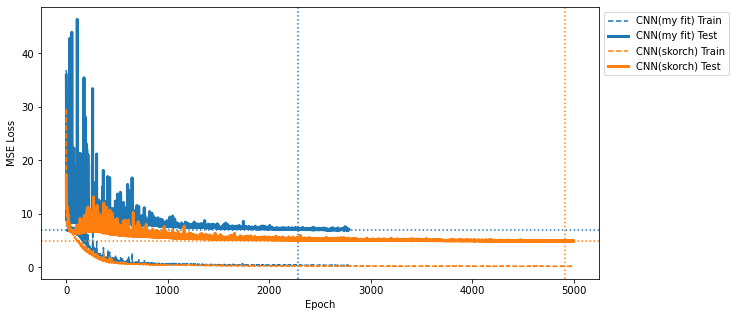

In [61]:
tu.quick_loss_plot(cnn_data_label+skorch_cnn_data_label)

In [64]:
#y_pred = net_regr.predict(X[:5])
y_pred = net_regr.predict(X)
y_pred = torch.tensor(y_pred).to(DEVICE)

net_regr.get_loss(y_pred, y)


tensor(1.0685, device='cuda:0')

TRAIN
Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


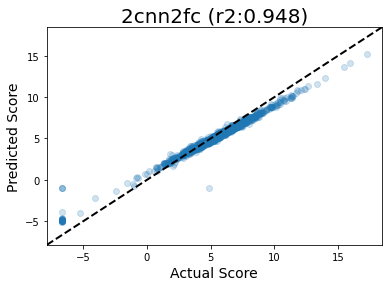

Running 2cnn2fc skorch
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


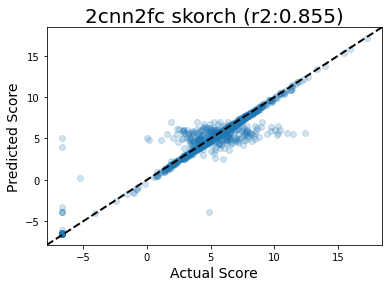

VAL
Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


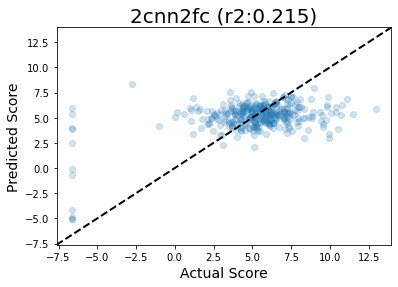

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


Running 2cnn2fc skorch
<class 'list'>


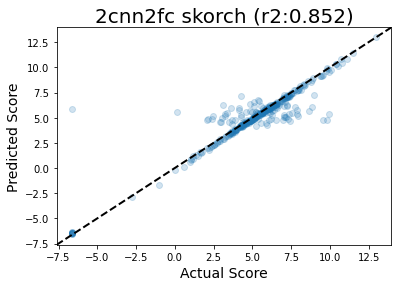

TEST
Running 2cnn2fc
<class 'list'>


/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


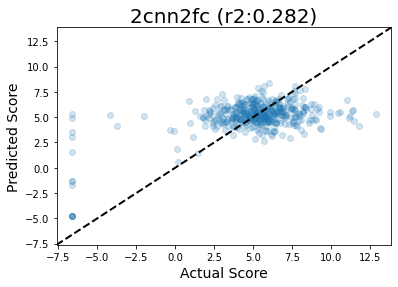

/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
/home/ubuntu/workspace/deep-5g-sandbox/torch_utils.py:572: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df = df[[locus_col]]


Running 2cnn2fc skorch
<class 'list'>


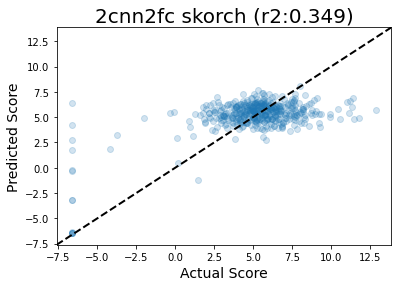

In [67]:
models = [
    ("2cnn2fc",model_cnn),
    ("2cnn2fc skorch",net_regr.module_)
]

print("TRAIN")
train_dfs = tu.parity_pred_loci(models,log_train_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("VAL")
val_dfs = tu.parity_pred_loci(models,log_val_df,DEVICE,seq_col='upstream_region',target_col='highCu')
print("TEST")
test_dfs  = tu.parity_pred_loci(models,log_test_df,DEVICE,seq_col='upstream_region',target_col='highCu')


## now try random search with some params

In [165]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform,uniform
from random import randint


In [166]:
net_search = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    callbacks=[
        EarlyStopping(patience=25),
        Checkpoint(dirname='testcheck_search',f_pickle='model.pkl')]

)

In [167]:
params = {
    'lr': [0.001, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

In [173]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=10, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [174]:
search.fit(X,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       20.5001       12.1226     +  0.0444
      2        8.8593        7.7914     +  0.0439
      3        7.7712        7.1144     +  0.0432


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished


      4        7.0550        7.0611     +  0.0438
      5        7.0852        7.0057     +  0.0439
      6        6.8806        6.8651     +  0.0442
      7        6.6989        6.7880     +  0.0434
      8        6.5779        6.7338     +  0.0435
      9        6.4366        6.6726     +  0.0438
     10        6.2821        6.6044     +  0.0433
     11        6.1256        6.5384     +  0.0435
     12        5.9686        6.4770     +  0.0434
     13        5.8096        6.4209     +  0.0432
     14        5.6456        6.3712     +  0.0436
     15        5.4737        6.3299     +  0.0430
     16        5.2930        6.3006     +  0.0430
     17        5.1060        6.2883     +  0.0437
     18        4.9173        6.2988        0.0433
     19        4.7319        6.3372        0.0435
     20        4.5542        6.4048        0.0433
     21        4.3878        6.4978        0.0434
     22        4.2364        6.6091        0.0431
     23        4.1020        6.7312        0.0437


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN'>,
  module__seq_len=300,
),
                   n_jobs=-1,
                   param_distributions={'lr': [0.001, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class 'torch.optim.adamw.A

In [175]:
print(search.best_params_)
#print(search.best_estimator_)

{'optimizer': <class 'torch.optim.adam.Adam'>, 'module__num_filters': 16, 'module__num_fc_nodes1': 10, 'module__kernel_size': 32, 'lr': 0.001}


In [176]:
import pickle


In [177]:
thing = pickle.load(open("testcheck_search/model.pkl",'rb'))
print(thing.optimizer)
print(thing._kwargs)


<class 'torch.optim.adam.Adam'>
{'module__seq_len': 300, 'module__num_filters': 16, 'module__num_fc_nodes1': 10, 'module__kernel_size': 32}


In [63]:
thing.best_estimator_.predict(X)

array([[ 5.8633976],
       [ 5.2869716],
       [ 6.659303 ],
       ...,
       [ 5.5561056],
       [ 4.9248676],
       [10.518184 ]], dtype=float32)

In [64]:
search_label2 = [((search.best_estimator_.history[:, 'train_loss'], search.best_estimator_.history[:, 'valid_loss']), 'CNN search2')]

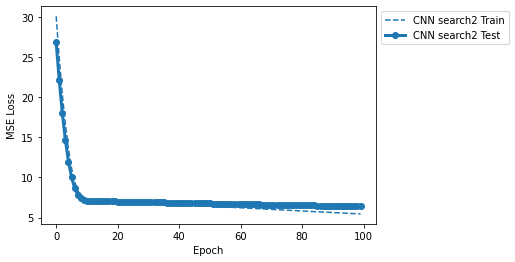

In [69]:
quick_loss_plot_simple(search_label2)

In [70]:
quick_loss_plot_simple(cnn_data_label+ skorch_label+search_label2)

NameError: name 'cnn_data_label' is not defined

In [71]:
# search history all losses?
search.best_estimator_.callbacks

## Compare some scores of the model combos tested

In [41]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,8.672382,1.273625,0.008405,0.000380,<class 'torch.optim.adam.Adam'>,16,10,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-16.179955,-17.348263,-17.114014,-17.671894,-20.874052,-17.837635,1.597393,79,Adam
1,6.532486,0.599377,0.009032,0.000312,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.597996,-5.747299,-8.053168,-6.293436,-8.273332,-6.993046,0.996032,15,Adam
2,7.413659,0.130496,0.009733,0.000691,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-13.050123,-14.679418,-13.992995,-14.277688,-15.210647,-14.242174,0.722974,66,Adam
3,6.375275,0.585531,0.008638,0.000714,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-11.934196,-11.819713,-12.456670,-11.711022,-13.410325,-12.266385,0.626594,57,Adam
4,4.912613,0.897008,0.009204,0.001720,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.968347,-5.693146,-8.473737,-6.256790,-8.357043,-7.149812,1.110178,26,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.767984,0.375863,0.017209,0.012649,<class 'torch.optim.adagrad.Adagrad'>,128,25,8,0.001,{'optimizer': <class 'torch.optim.adagrad.Adag...,-10.501407,-10.481804,-10.642952,-11.798771,-13.074899,-11.299966,1.013701,53,Adagrad
96,4.690087,0.300074,0.008552,0.000081,<class 'torch.optim.sgd.SGD'>,16,10,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-9.152666,-23.795935,-14.424869,-9.805436,-12.968714,-14.029524,5.259107,65,SGD
97,5.611043,0.051608,0.008662,0.000532,<class 'torch.optim.adam.Adam'>,32,50,32,0.001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-19.122482,-22.754072,-18.900936,-20.724274,-23.525520,-21.005457,1.868799,87,Adam
98,4.664388,0.083527,0.008588,0.000184,<class 'torch.optim.sgd.SGD'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-23.160917,-10.017928,-14.869970,-6.681670,-14.361557,-13.818408,5.550855,64,SGD


In [42]:
sm_res_df = res_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [43]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [44]:
alt.Chart(sm_res_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

## Check prediction distributions

In [52]:
Xval, yval = make_skorch_dfs(log_val_df, seq_col='upstream_region',target_col='highCu')
Xtest, ytest = make_skorch_dfs(log_test_df, seq_col='upstream_region',target_col='highCu')



In [53]:
# y pred and pearson on training data
ypred_train_basic = net_regr.predict(X)
ypred_train_search = search.best_estimator_.predict(X)
p_train_basic = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_basic.flatten())
p_train_search = scipy.stats.pearsonr(np.array(y).flatten(),ypred_train_search.flatten())

# y pred and pearson on val data
ypred_val_basic = net_regr.predict(Xval)
ypred_val_search = search.best_estimator_.predict(Xval)
p_val_basic = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_basic.flatten())
p_val_search = scipy.stats.pearsonr(np.array(yval).flatten(),ypred_val_search.flatten())

# y pred and pearson on test data
ypred_test_basic = net_regr.predict(Xtest)
ypred_test_search = search.best_estimator_.predict(Xtest)
p_test_basic = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_basic.flatten())
p_test_search = scipy.stats.pearsonr(np.array(ytest).flatten(),ypred_test_search.flatten())



In [54]:
def ytrue_pred_hist(y,ypred,title):
    plt.hist(ypred,alpha=0.2, label="Y Pred")
    plt.hist(np.array(y),alpha=0.2, label="Y True")
    plt.legend()
    plt.title(title)
    plt.show()
    

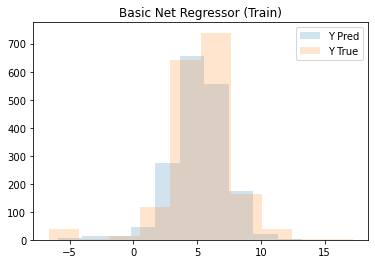

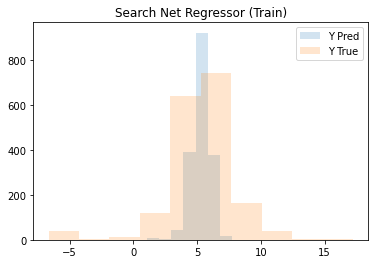

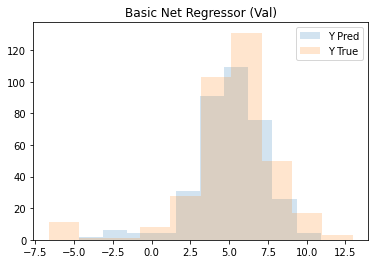

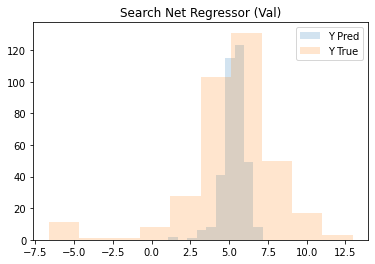

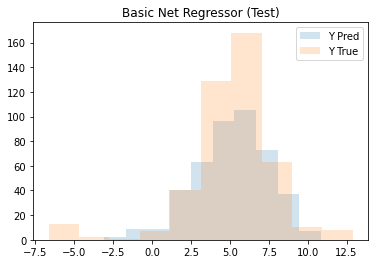

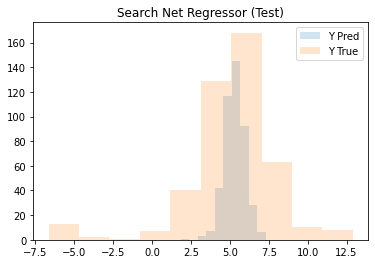

In [55]:
ytrue_pred_hist(y,ypred_train_basic,"Basic Net Regressor (Train)")
ytrue_pred_hist(y,ypred_train_search,"Search Net Regressor (Train)")

ytrue_pred_hist(yval,ypred_val_basic,"Basic Net Regressor (Val)")
ytrue_pred_hist(yval,ypred_val_search,"Search Net Regressor (Val)")

ytrue_pred_hist(ytest,ypred_test_basic,"Basic Net Regressor (Test)")
ytrue_pred_hist(ytest,ypred_test_search,"Search Net Regressor (Test)")

In [84]:
def parity_plot(model,ytrue,ypred, pearson,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()

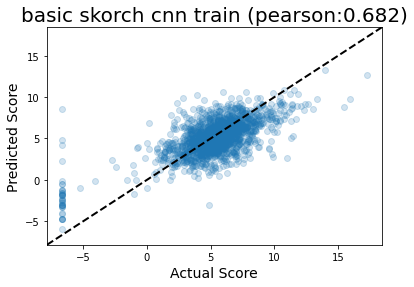

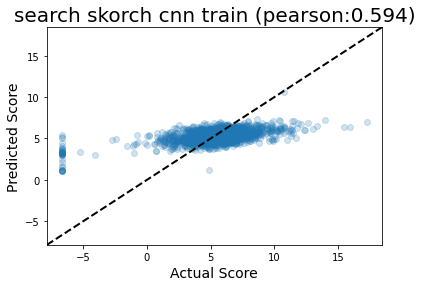

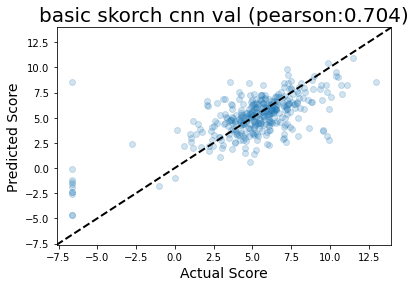

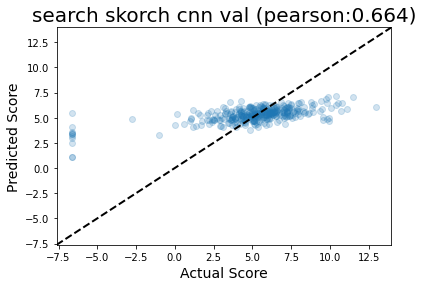

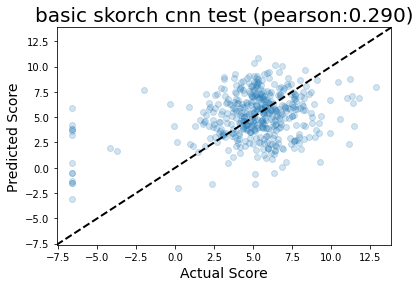

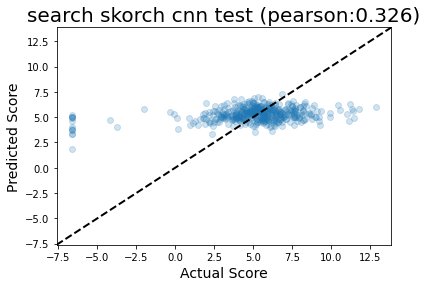

In [87]:
parity_plot("basic skorch cnn train", y, ypred_train_basic,p_train_basic[0],rigid=True)
parity_plot("search skorch cnn train", y, ypred_train_search,p_train_search[0],rigid=True)

parity_plot("basic skorch cnn val", yval, ypred_val_basic,p_val_basic[0],rigid=True)
parity_plot("search skorch cnn val", yval, ypred_val_search,p_val_search[0],rigid=True)

parity_plot("basic skorch cnn test", ytest, ypred_test_basic,p_test_basic[0],rigid=True)
parity_plot("search skorch cnn test", ytest, ypred_test_search,p_test_search[0],rigid=True)

In [51]:
b = search.best_estimator_
for i in b.module_.children():
    if type(i) == nn.Sequential:
        for child in i:
            if type(child) == nn.Conv2d:
                print(child.weight)

Parameter containing:
tensor([[[[ 3.4057e-02,  4.3642e-02, -1.9904e-01, -2.7334e-02],
          [-2.0415e-01, -1.3838e-01, -2.2525e-01,  1.6372e-01],
          [ 5.9070e-02,  1.4298e-01,  1.9506e-01, -2.2385e-01],
          [ 6.8632e-02, -2.0406e-01,  8.4021e-02, -2.0967e-01]]],


        [[[-1.1542e-01, -1.7631e-01, -6.6347e-02, -2.1405e-01],
          [ 9.5700e-02, -1.0333e-01,  1.9630e-01, -1.0735e-01],
          [-1.2648e-01,  1.3538e-01,  8.7525e-04,  1.5259e-01],
          [-1.8498e-01,  1.1219e-01,  6.2805e-02,  1.1183e-01]]],


        [[[ 1.8494e-01, -1.2967e-01, -1.4420e-01, -2.1125e-01],
          [ 1.0075e-02,  1.1691e-01, -1.2725e-03,  1.5102e-01],
          [ 1.5237e-01,  9.9624e-02, -6.9806e-02,  4.0394e-02],
          [ 2.1143e-01, -1.0865e-01, -1.8518e-01,  2.0652e-01]]],


        ...,


        [[[ 6.1595e-02, -1.4699e-01,  4.3739e-02,  2.3188e-01],
          [ 1.3863e-01, -3.9582e-02,  1.7993e-01, -8.9094e-02],
          [ 7.1283e-04, -5.9587e-02, -1.7954e-02, -2.26

In [58]:
b.score(Xtest,ytest)

0.09038980006140596

# Run skorch with a Pytorch data loader

In [202]:
net_dl = NeuralNetRegressor(
    DNA_CNN,
    module__seq_len=300,
    max_epochs=100,
    #lr=0.001,
    device='cuda',  # uncomment this to train with CUDA
    iterator_train = log_ohe_train_dl,
    iterator_valid = log_ohe_val_dl
)

In [203]:
search_dl = RandomizedSearchCV(
    net_dl, 
    params, 
    n_iter=200, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=1,
    verbose=2
)

In [204]:
search_dl.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   30.0s finished


TypeError: 'DataLoader' object is not callable

The FAQ seems to say to NOT provide a Dataset if possible - skorch does Dataloader stuff under the hood? 

"skorch supports datasets as input but sklearn doesn’t. If it’s possible, you should provide your data in a non-dataset format, e.g. as a numpy array or torch tensor, extracted from your original dataset."
https://skorch.readthedocs.io/en/stable/user/FAQ.html#faq-how-do-i-use-a-pytorch-dataset-with-skorch

# Run Skorch with MT model

In [59]:
condition_file = 'data/conditions_to_include.txt'
with open(condition_file,'r') as f:
    conditions = list(x.strip() for x in f.readlines())
    
cond_dict = dict(enumerate(conditions))
cond_dict

{0: 'uMax',
 1: 'lowO2_fast_growth',
 2: 'lowCH4',
 3: 'MeOH',
 4: 'NoCu',
 5: 'medCu',
 6: 'highCu',
 7: 'lowCu',
 8: 'highO2_slow_growth',
 9: 'NO3_lowO2_slow_growth',
 10: 'WithLanthanum',
 11: 'NoLanthanum'}

In [60]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=5,
                 num_fc_nodes1=100,
                 num_fc_nodes2=10
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            #nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, num_fc_nodes1),
            nn.Linear(num_fc_nodes1, num_fc_nodes2),
        )
        # define the multi task objectives?
        self.obj0   = nn.Linear(num_fc_nodes2,1)
        self.obj1   = nn.Linear(num_fc_nodes2,1)
        self.obj2   = nn.Linear(num_fc_nodes2,1)
        self.obj3   = nn.Linear(num_fc_nodes2,1)
        self.obj4   = nn.Linear(num_fc_nodes2,1)
        self.obj5   = nn.Linear(num_fc_nodes2,1)
        self.obj6   = nn.Linear(num_fc_nodes2,1)
        self.obj7   = nn.Linear(num_fc_nodes2,1)
        self.obj8   = nn.Linear(num_fc_nodes2,1)
        self.obj9   = nn.Linear(num_fc_nodes2,1)
        self.obj10  = nn.Linear(num_fc_nodes2,1)
        self.obj11  = nn.Linear(num_fc_nodes2,1)
        

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        
        out0 = self.obj0(out).squeeze(1)
        out1 = self.obj1(out).squeeze(1)
        out2 = self.obj2(out).squeeze(1)
        out3 = self.obj3(out).squeeze(1)
        out4 = self.obj4(out).squeeze(1)
        out5 = self.obj5(out).squeeze(1)
        out6 = self.obj6(out).squeeze(1)
        out7 = self.obj7(out).squeeze(1)
        out8 = self.obj8(out).squeeze(1)
        out9 = self.obj9(out).squeeze(1)
        out10 = self.obj10(out).squeeze(1)
        out11 = self.obj11(out).squeeze(1)
        
        #print("out0", out0.shape)
        all_outs = torch.stack([out0,out1,out2,out3,out4,out5,out6,out7,out8,out9,out10,out11])
        #print("all_outs",all_outs.shape)
#         print("convert list to tensor?")
#         all_outs = torch.tensor(all_outs)
#         print(all_outs.shape)
        #print(all_outs)
#    shape fix here??
        #print("all_outs shape", all_outs.shape)
        #print("transpose?", all_outs.T.shape)
        
        #all_outs.squeeze(2)
        
        return all_outs.T

In [61]:
def make_multi_skorch_dfs(df,seq_col='seq',target_cols=conditions):
    ### EDIT THIS FOR MULTI TASK!
    
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [65]:
Xm,ym = make_multi_skorch_dfs(log_full_train_df, seq_col='upstream_region')
print("X:",X.shape)
print("y:",y.shape)

X: torch.Size([1763, 300, 4])
y: torch.Size([1763, 1])


In [66]:
mnet_regr = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=100,
    lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

In [67]:
mnet_regr.fit(Xm, ym)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.8529       33.7938  0.0651
      2       34.5523       33.5005  0.0627
      3       34.2513       33.2046  0.0628
      4       33.9460       32.9023  0.0620
      5       33.6326       32.5900  0.0629
      6       33.3075       32.2640  0.0620
      7       32.9666       31.9202  0.0617
      8       32.6058       31.5545  0.0624
      9       32.2207       31.1623  0.0621
     10       31.8064       30.7386  0.0621
     11       31.3577       30.2779  0.0625
     12       30.8685       29.7741  0.0629
     13       30.3325       29.2206  0.0622
     14       29.7425       28.6100  0.0634
     15       29.0908       27.9346  0.0634
     16       28.3692       27.1861  0.0627
     17       27.5692       26.3563  0.0619
     18       26.6822       25.4372  0.0620
     19       25.7005       24.4221  0.0629
     20       24.6180       23.3069  0.0622
     21       23.4316       22.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 31, kernel_size=(4, 5), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=9176, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

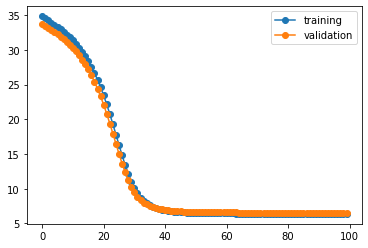

In [68]:
train_loss = mnet_regr.history[:, 'train_loss']
valid_loss = mnet_regr.history[:, 'valid_loss']

plt.plot(train_loss, 'o-', label='training')
plt.plot(valid_loss, 'o-', label='validation')
plt.legend()
plt.show()

In [69]:
ympred_train = mnet_regr.predict(Xm)
ympred_train.shape

(1763, 12)

### Loop through each task and look at parity plot?

In [85]:
def check_mt_pred_results(y,ypred,title):
    '''
    Check individual task predictions within MT?
    '''
    for i in cond_dict:
        task=cond_dict[i]
        subtitle = f"{task} - {title}"
        print(f"task:{task}")
        yi = y[:,i]
        ypredi = ypred[:,i]

        pr = scipy.stats.pearsonr(np.array(yi).flatten(),ypredi.flatten())
        ytrue_pred_hist(yi,ypredi,subtitle)
        parity_plot(f"skorch cnn {task}", yi, ypredi,pr[0],rigid=True)

task:uMax


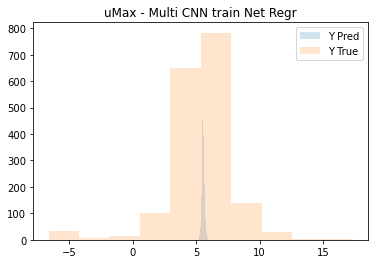

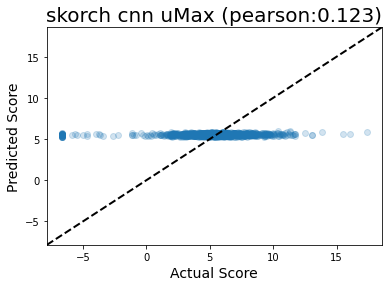

task:lowO2_fast_growth


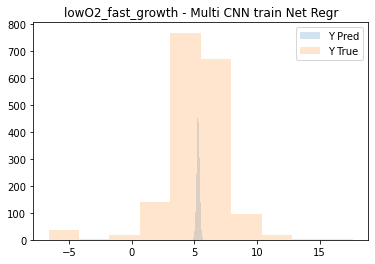

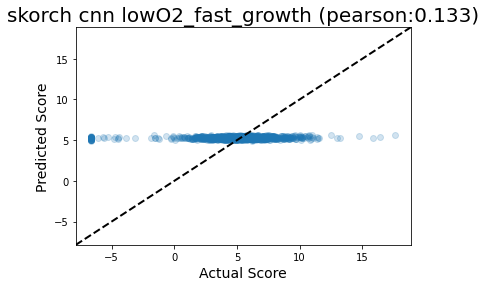

task:lowCH4


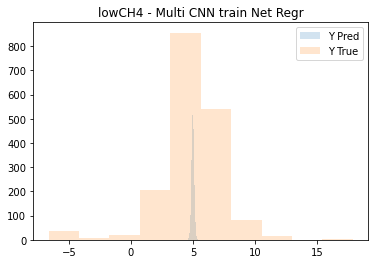

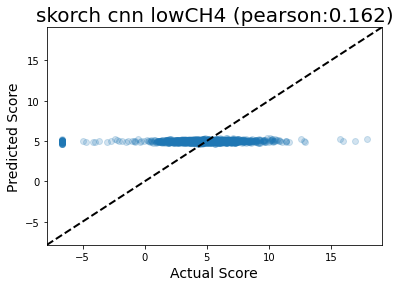

task:MeOH


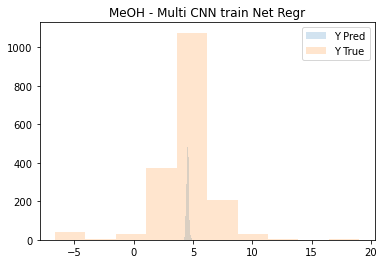

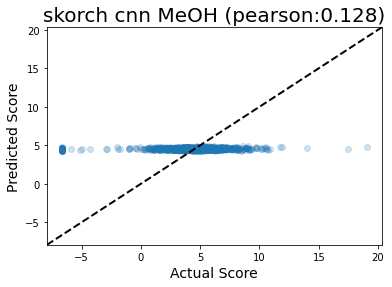

task:NoCu


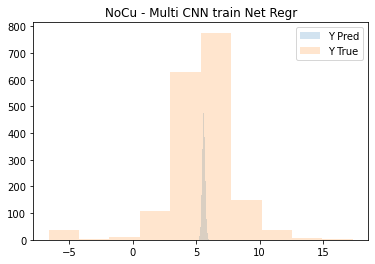

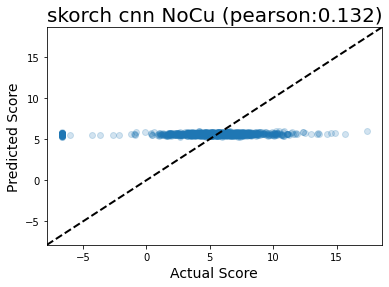

task:medCu


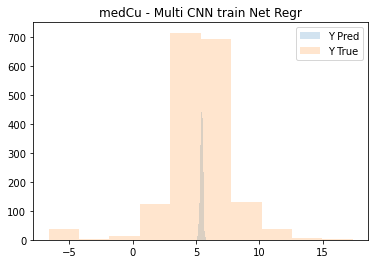

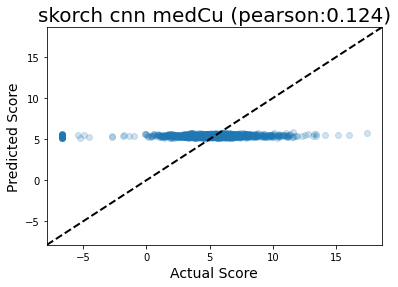

task:highCu


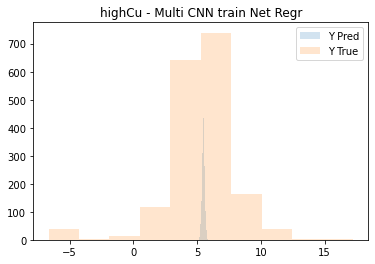

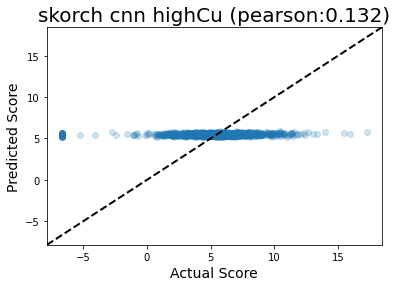

task:lowCu


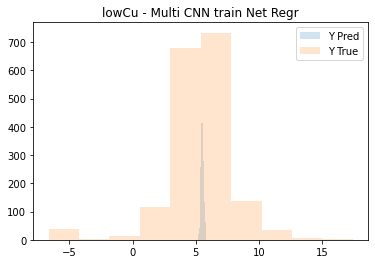

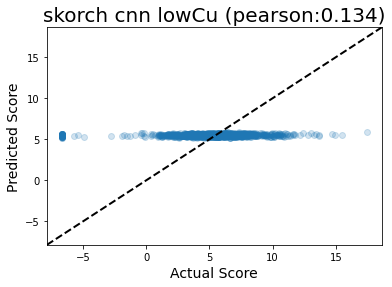

task:highO2_slow_growth


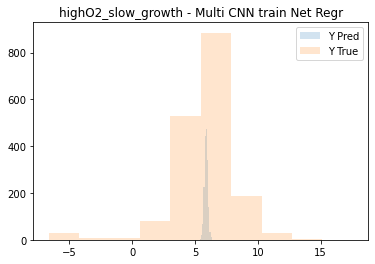

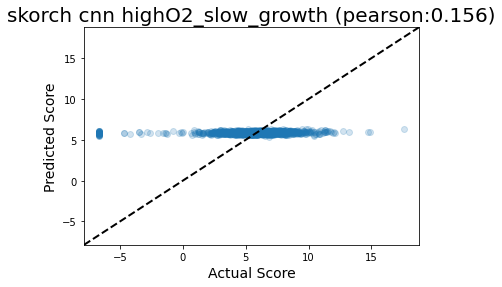

task:NO3_lowO2_slow_growth


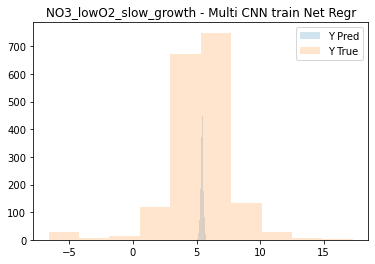

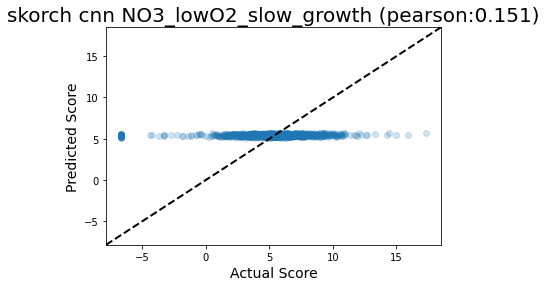

task:WithLanthanum


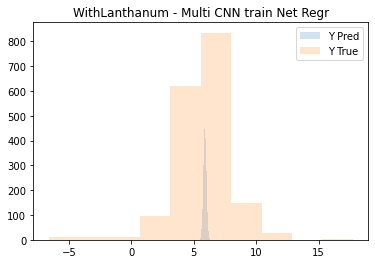

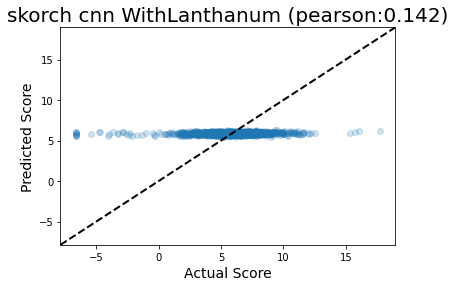

task:NoLanthanum


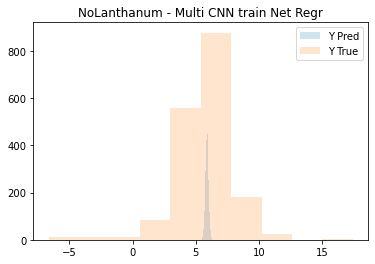

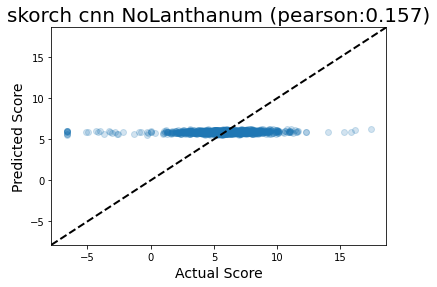

In [86]:
check_mt_pred_results(ym, ympred_train, "Multi CNN train Net Regr")

# skorch param search with MT

In [88]:
params = {
    'lr': [0.0005, 0.0001,0.00001],#loguniform(0.0001, 0.01)
    
    'module__num_filters': [16,32,64,128], # uniform(8,128), #
    'module__kernel_size': [4,8,16,32],
    'module__num_fc_nodes1': [10, 25, 50,100], #randint(10,100), #
    'optimizer':[torch.optim.SGD, torch.optim.Adam, torch.optim.Adagrad,torch.optim.AdamW,torch.optim.RMSprop]
    #'optimizer__nesterov': [False, True],
}

mnet_search = NeuralNetRegressor(
    DNA_CNN_Multi,
    module__seq_len=300,
    max_epochs=500,
    #lr=0.0001,
    device='cuda',  # uncomment this to train with CUDA
)

m_search = RandomizedSearchCV(
    mnet_search, 
    params, 
    n_iter=500, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=5,#cv, 
    random_state=1,
    verbose=2
)

In [89]:
m_search.fit(Xm, ym)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 86.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 147.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 227.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 328.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 448.6min


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.2929       32.3014  0.0699
      2       32.4298       30.6530  0.0684


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 565.9min finished


      3       30.7913       29.1553  0.0686
      4       29.2710       27.7340  0.0655
      5       27.8080       26.3470  0.0656
      6       26.3686       24.9726  0.0654
      7       24.9369       23.6026  0.0643
      8       23.5092       22.2382  0.0644
      9       22.0897       20.8868  0.0639
     10       20.6881       19.5592  0.0632
     11       19.3170       18.2679  0.0637
     12       17.9898       17.0258  0.0634
     13       16.7197       15.8443  0.0626
     14       15.5183       14.7336  0.0627
     15       14.3952       13.7014  0.0635
     16       13.3575       12.7532  0.0629
     17       12.4099       11.8919  0.0630
     18       11.5542       11.1183  0.0627
     19       10.7899       10.4307  0.0634
     20       10.1143        9.8256  0.0631
     21        9.5229        9.2981  0.0626
     22        9.0098        8.8422  0.0625
     23        8.5684        8.4512  0.0622
     24        8.1914        8.1181  0.0623
     25        7.8716        7.8

    136        5.8347        6.1929  0.0617
    137        5.8298        6.1904  0.0616
    138        5.8250        6.1880  0.0615
    139        5.8201        6.1856  0.0620
    140        5.8153        6.1832  0.0617
    141        5.8104        6.1807  0.0618
    142        5.8055        6.1783  0.0617
    143        5.8007        6.1759  0.0618
    144        5.7958        6.1735  0.0622
    145        5.7909        6.1710  0.0622
    146        5.7860        6.1686  0.0627
    147        5.7811        6.1662  0.0623
    148        5.7762        6.1638  0.0619
    149        5.7713        6.1613  0.0619
    150        5.7664        6.1589  0.0622
    151        5.7615        6.1565  0.0628
    152        5.7565        6.1541  0.0626
    153        5.7516        6.1517  0.0620
    154        5.7467        6.1492  0.0620
    155        5.7417        6.1468  0.0622
    156        5.7368        6.1444  0.0620
    157        5.7318        6.1420  0.0620
    158        5.7269        6.1

    269        5.1448        5.8799  0.0618
    270        5.1393        5.8777  0.0618
    271        5.1338        5.8755  0.0624
    272        5.1283        5.8732  0.0617
    273        5.1227        5.8710  0.0619
    274        5.1172        5.8688  0.0618
    275        5.1117        5.8666  0.0616
    276        5.1061        5.8644  0.0617
    277        5.1005        5.8622  0.0617
    278        5.0950        5.8600  0.0619
    279        5.0894        5.8578  0.0620
    280        5.0839        5.8556  0.0626
    281        5.0783        5.8534  0.0620
    282        5.0727        5.8512  0.0622
    283        5.0671        5.8490  0.0623
    284        5.0616        5.8468  0.0617
    285        5.0560        5.8447  0.0618
    286        5.0504        5.8425  0.0617
    287        5.0448        5.8403  0.0619
    288        5.0392        5.8382  0.0623
    289        5.0336        5.8360  0.0620
    290        5.0280        5.8338  0.0619
    291        5.0224        5.8

    402        4.3896        5.6356  0.0624
    403        4.3840        5.6344  0.0625
    404        4.3784        5.6333  0.0623
    405        4.3728        5.6321  0.0621
    406        4.3672        5.6309  0.0621
    407        4.3616        5.6298  0.0624
    408        4.3560        5.6287  0.0627
    409        4.3505        5.6276  0.0625
    410        4.3449        5.6265  0.0626
    411        4.3393        5.6254  0.0625
    412        4.3338        5.6243  0.0626
    413        4.3282        5.6233  0.0625
    414        4.3227        5.6222  0.0632
    415        4.3172        5.6212  0.0634
    416        4.3117        5.6202  0.0637
    417        4.3061        5.6192  0.0636
    418        4.3006        5.6182  0.0642
    419        4.2951        5.6173  0.0633
    420        4.2897        5.6163  0.0630
    421        4.2842        5.6154  0.0633
    422        4.2787        5.6145  0.0628
    423        4.2732        5.6136  0.0627
    424        4.2678        5.6

RandomizedSearchCV(cv=5,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.DNA_CNN_Multi'>,
  module__seq_len=300,
),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'lr': [0.0005, 0.0001, 1e-05],
                                        'module__kernel_size': [4, 8, 16, 32],
                                        'module__num_fc_nodes1': [10, 25, 50,
                                                                  100],
                                        'module__num_filters': [16, 32, 64,
                                                                128],
                                        'optimizer': [<class 'torch.optim.sgd.SGD'>,
                                                      <class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.adagrad.Adagrad'>,
                                                      <class '

In [90]:
m_search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): Flatten()
      (2): Linear(in_features=38016, out_features=25, bias=True)
      (3): Linear(in_features=25, out_features=10, bias=True)
    )
    (obj0): Linear(in_features=10, out_features=1, bias=True)
    (obj1): Linear(in_features=10, out_features=1, bias=True)
    (obj2): Linear(in_features=10, out_features=1, bias=True)
    (obj3): Linear(in_features=10, out_features=1, bias=True)
    (obj4): Linear(in_features=10, out_features=1, bias=True)
    (obj5): Linear(in_features=10, out_features=1, bias=True)
    (obj6): Linear(in_features=10, out_features=1, bias=True)
    (obj7): Linear(in_features=10, out_features=1, bias=True)
    (obj8): Linear(in_features=10, out_features=1, bias=True)
    (obj9): Linear(in_features=10, out_features=1, bias=True)
    (obj10): Linear(in_features=10, out_features=1, 

In [91]:
m_search.best_params_

{'optimizer': torch.optim.sgd.SGD,
 'module__num_filters': 128,
 'module__num_fc_nodes1': 25,
 'module__kernel_size': 4,
 'lr': 0.0001}

In [92]:
mres_df = pd.DataFrame(m_search.cv_results_)
mres_df['opt_name'] = mres_df['param_optimizer'].apply(lambda x: x.__name__)
mres_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,59.104487,0.685902,0.010845,0.001480,<class 'torch.optim.adam.Adam'>,16,10,32,0.0005,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.853952,-23.230394,-21.319815,-22.497879,-22.695402,-21.719489,1.562829,376,Adam
1,59.337368,2.253942,0.013646,0.002544,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.946605,-5.320988,-7.279854,-5.753273,-8.405795,-6.541303,1.138913,123,Adam
2,62.643943,0.526686,0.014259,0.001357,<class 'torch.optim.adam.Adam'>,128,25,8,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-17.657255,-21.508598,-20.662313,-21.507624,-22.012827,-20.669724,1.567465,355,Adam
3,57.970003,2.599069,0.011775,0.001051,<class 'torch.optim.adam.Adam'>,32,100,4,0.0001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.295582,-19.663145,-19.988087,-18.631847,-20.820629,-19.479858,0.917735,340,Adam
4,40.366428,4.052095,0.012646,0.002078,<class 'torch.optim.sgd.SGD'>,32,25,4,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.104009,-4.963671,-7.213747,-5.209205,-7.599255,-6.217977,1.049131,47,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,54.819225,1.421057,0.013606,0.001281,<class 'torch.optim.rmsprop.RMSprop'>,128,10,8,0.0005,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-19.959888,-24.360632,-22.448183,-22.932302,-22.832281,-22.506657,1.429257,413,RMSprop
496,56.441145,0.595706,0.011243,0.000335,<class 'torch.optim.adam.Adam'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.131781,-4.998219,-6.853837,-5.415829,-7.572523,-6.194438,0.935417,31,Adam
497,43.649200,5.467568,0.015853,0.005174,<class 'torch.optim.sgd.SGD'>,32,10,8,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-7.034853,-9.071085,-13.716123,-13.504837,-8.366921,-10.338764,2.751057,248,SGD
498,77.238276,5.039324,0.017579,0.003002,<class 'torch.optim.adam.Adam'>,128,100,16,0.0005,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-21.778761,-26.515709,-24.488634,-25.060144,-24.044800,-24.377610,1.543660,460,Adam


In [93]:
sm_mres_df = mres_df[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [94]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [95]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)

In [96]:
ymsearch_pred_train = m_search.best_estimator_.predict(Xm)

task:uMax


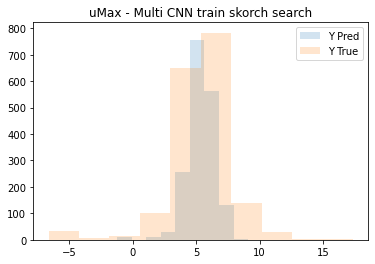

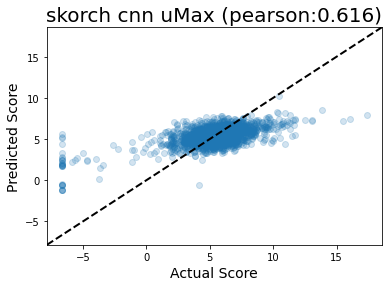

task:lowO2_fast_growth


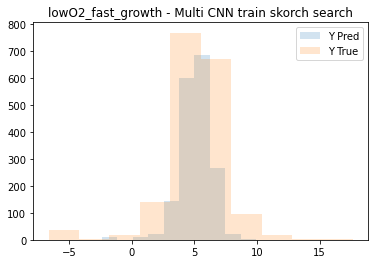

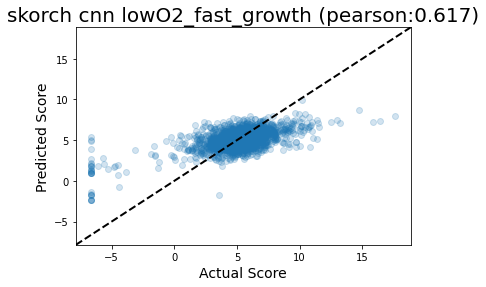

task:lowCH4


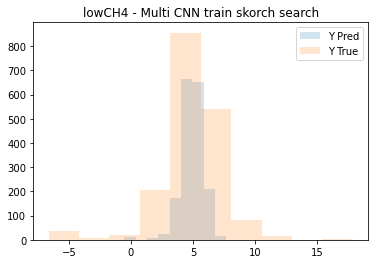

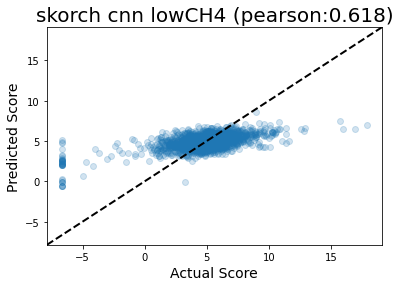

task:MeOH


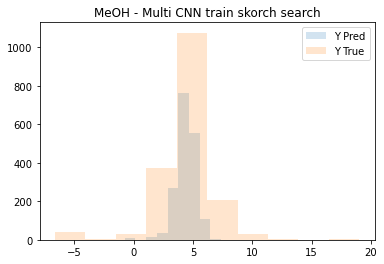

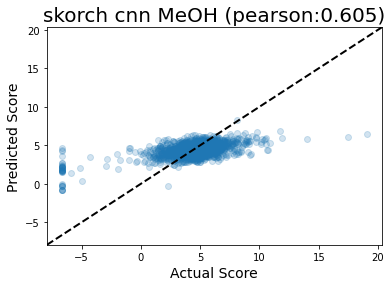

task:NoCu


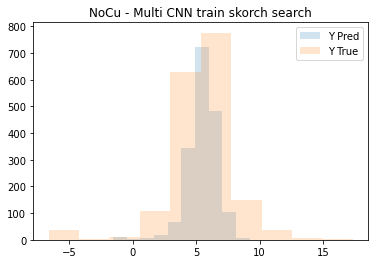

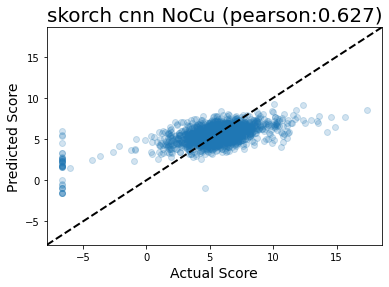

task:medCu


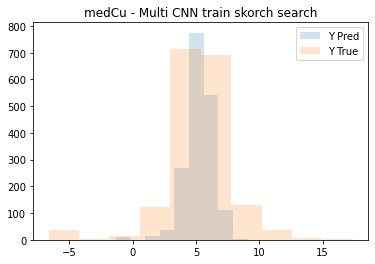

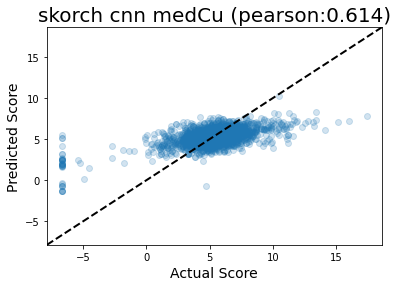

task:highCu


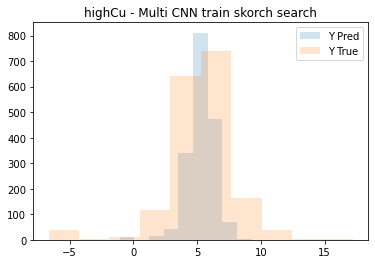

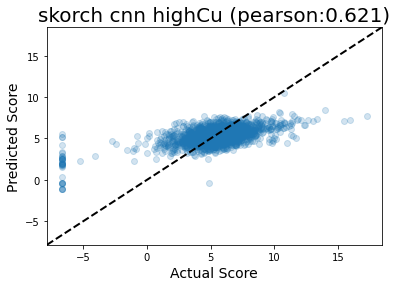

task:lowCu


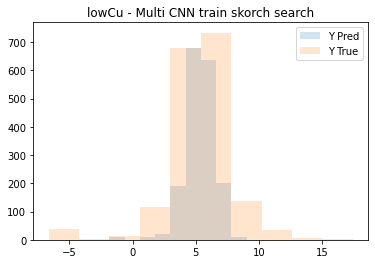

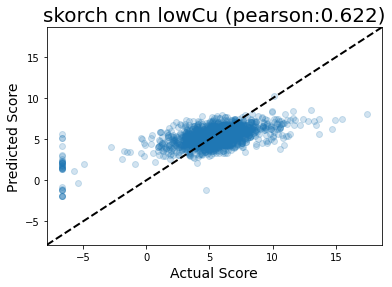

task:highO2_slow_growth


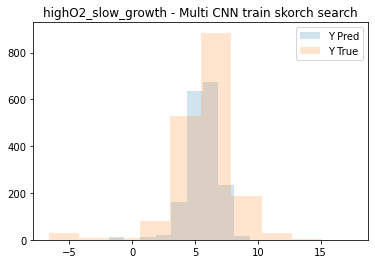

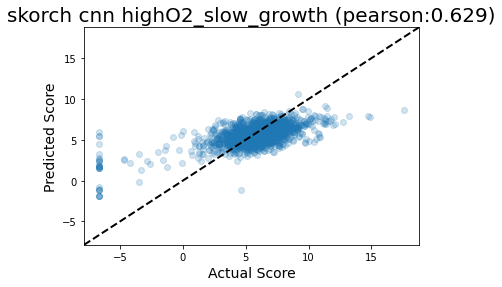

task:NO3_lowO2_slow_growth


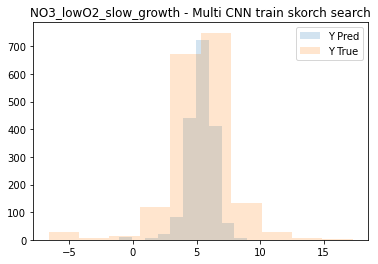

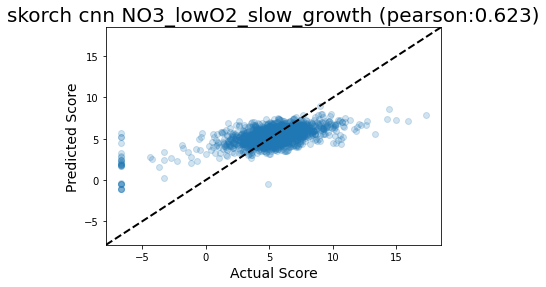

task:WithLanthanum


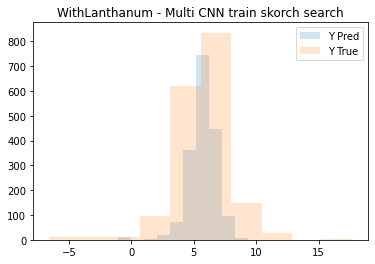

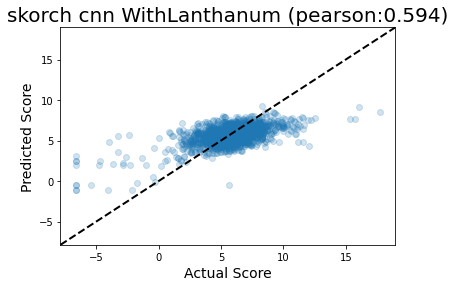

task:NoLanthanum


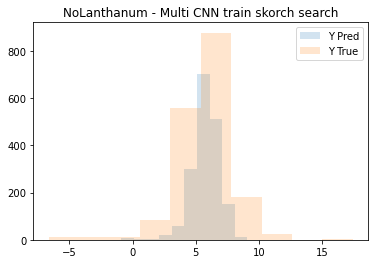

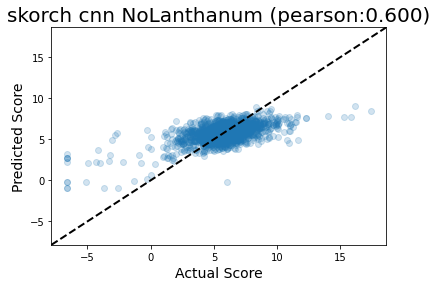

In [97]:
check_mt_pred_results(ym, ymsearch_pred_train,"Multi CNN train skorch search")

In [99]:
Xmtest,ymtest = make_multi_skorch_dfs(log_test_df, seq_col='upstream_region')
print("X m test:",Xmtest.shape)
print("y m test:",ymtest.shape)

X m test: torch.Size([441, 300, 4])
y m test: torch.Size([441, 12])


In [100]:
ymsearch_pred_test = m_search.best_estimator_.predict(Xmtest)

task:uMax


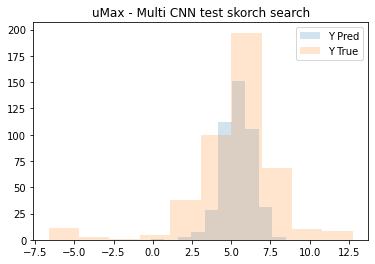

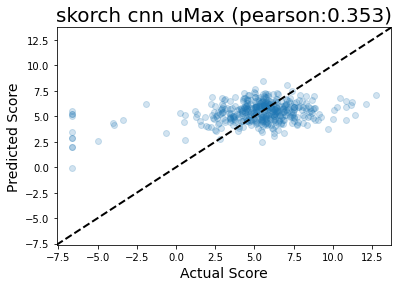

task:lowO2_fast_growth


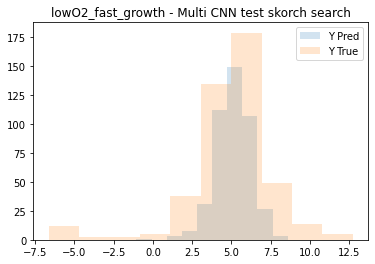

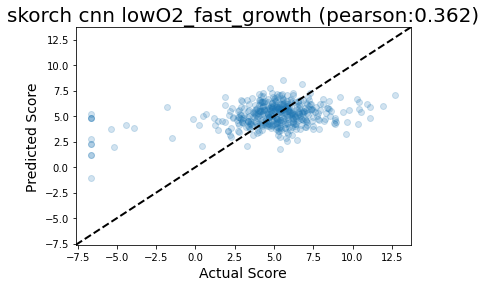

task:lowCH4


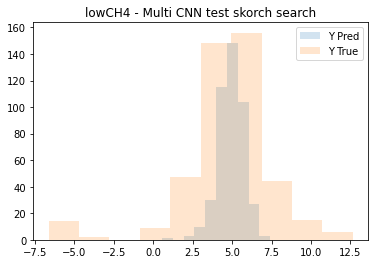

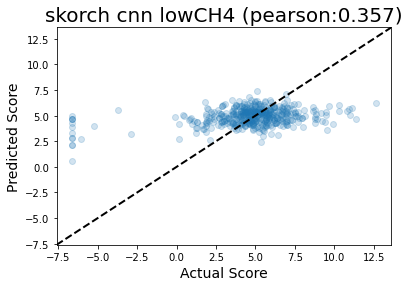

task:MeOH


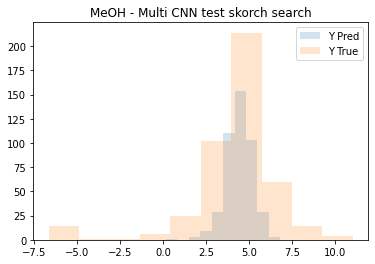

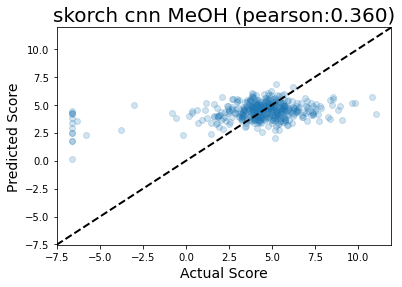

task:NoCu


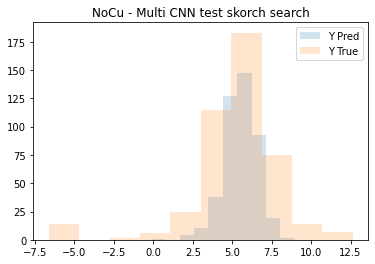

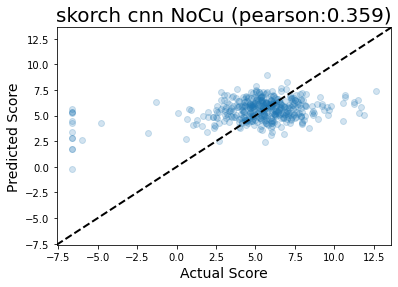

task:medCu


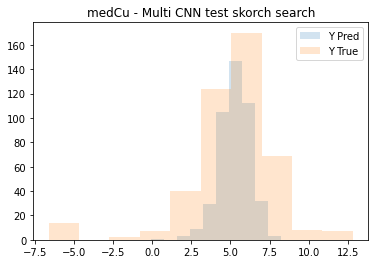

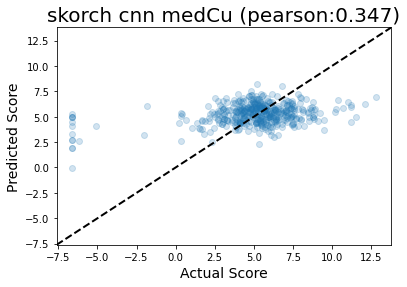

task:highCu


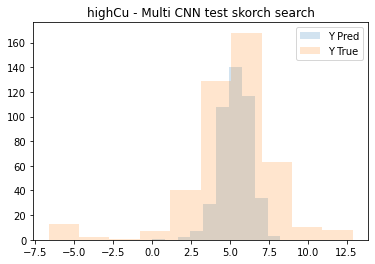

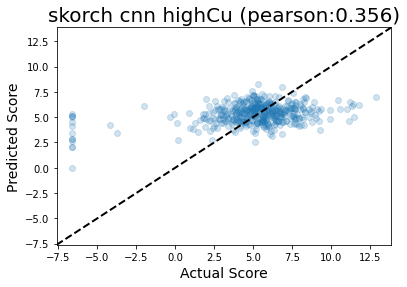

task:lowCu


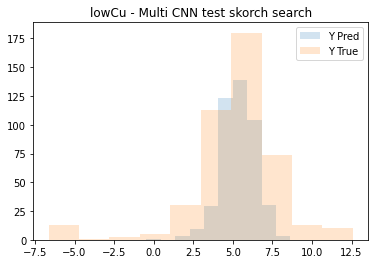

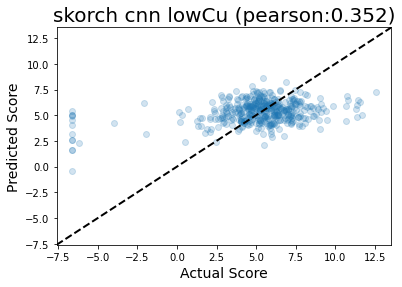

task:highO2_slow_growth


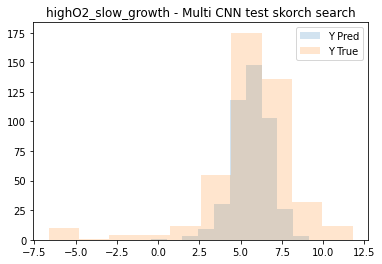

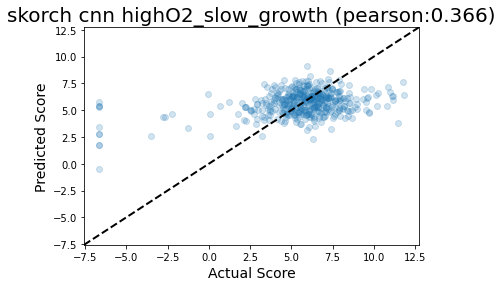

task:NO3_lowO2_slow_growth


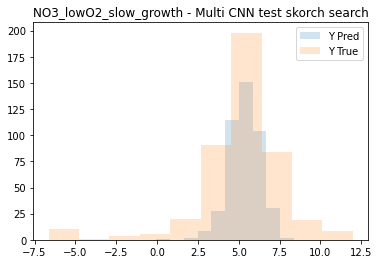

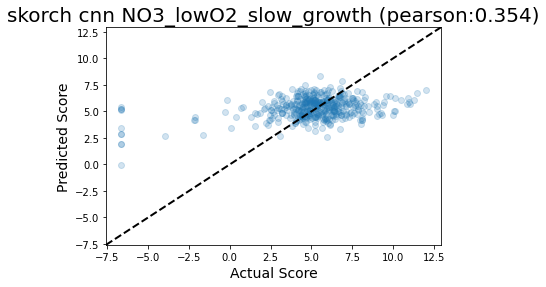

task:WithLanthanum


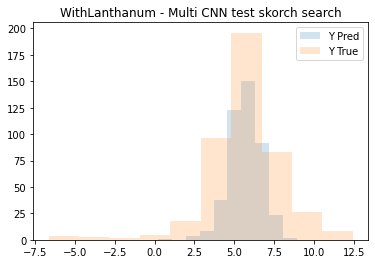

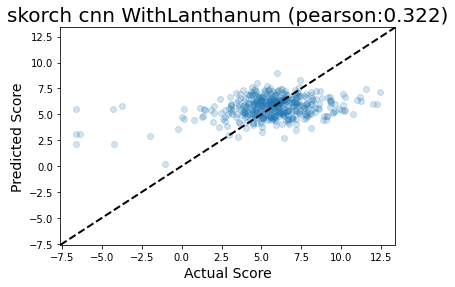

task:NoLanthanum


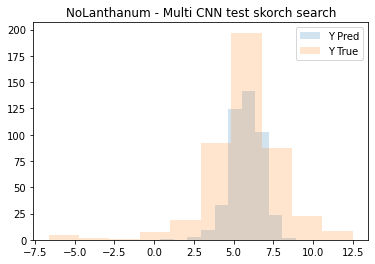

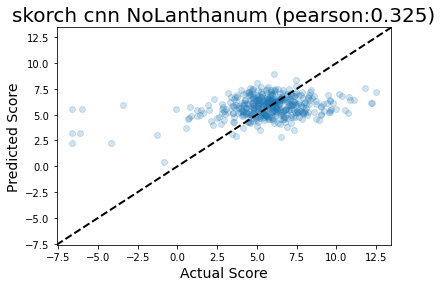

In [101]:
check_mt_pred_results(ymtest, ymsearch_pred_test,"Multi CNN test skorch search")

In [102]:
mres_df.to_csv("multi_skorch_search_res_df.tsv",sep='\t', index=False)

In [8]:
test = pd.read_csv('multi_skorch_search_res_df.tsv',sep='\t')

In [9]:
test

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters,param_module__num_fc_nodes1,param_module__kernel_size,param_lr,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,59.104487,0.685902,0.010845,0.001480,<class 'torch.optim.adam.Adam'>,16,10,32,0.00050,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.853952,-23.230394,-21.319815,-22.497879,-22.695402,-21.719489,1.562829,376,Adam
1,59.337368,2.253942,0.013646,0.002544,<class 'torch.optim.adam.Adam'>,64,50,16,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-5.946605,-5.320988,-7.279854,-5.753273,-8.405795,-6.541303,1.138913,123,Adam
2,62.643943,0.526686,0.014259,0.001357,<class 'torch.optim.adam.Adam'>,128,25,8,0.00010,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-17.657255,-21.508598,-20.662313,-21.507624,-22.012827,-20.669724,1.567465,355,Adam
3,57.970003,2.599069,0.011775,0.001051,<class 'torch.optim.adam.Adam'>,32,100,4,0.00010,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-18.295582,-19.663145,-19.988087,-18.631847,-20.820629,-19.479858,0.917735,340,Adam
4,40.366428,4.052095,0.012646,0.002078,<class 'torch.optim.sgd.SGD'>,32,25,4,0.00010,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-6.104009,-4.963671,-7.213747,-5.209205,-7.599255,-6.217977,1.049131,47,SGD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,54.819225,1.421057,0.013606,0.001281,<class 'torch.optim.rmsprop.RMSprop'>,128,10,8,0.00050,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-19.959888,-24.360632,-22.448183,-22.932302,-22.832281,-22.506657,1.429257,413,RMSprop
496,56.441145,0.595706,0.011243,0.000335,<class 'torch.optim.adam.Adam'>,16,100,4,0.00001,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-6.131781,-4.998219,-6.853837,-5.415829,-7.572523,-6.194438,0.935417,31,Adam
497,43.649200,5.467568,0.015853,0.005174,<class 'torch.optim.sgd.SGD'>,32,10,8,0.00001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-7.034853,-9.071085,-13.716123,-13.504837,-8.366921,-10.338764,2.751057,248,SGD
498,77.238276,5.039324,0.017579,0.003002,<class 'torch.optim.adam.Adam'>,128,100,16,0.00050,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-21.778761,-26.515709,-24.488634,-25.060144,-24.044800,-24.377610,1.543660,460,Adam


In [10]:
sm_mres_df = test[["rank_test_score","mean_test_score","param_module__num_filters","param_module__kernel_size","param_lr","param_module__num_fc_nodes1","opt_name"]]

In [11]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N"
    
).interactive()

alt.Chart(...)

In [12]:
alt.Chart(sm_mres_df).mark_point().encode(
    x='param_module__num_filters:O',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:Q',scale=alt.Scale(scheme='viridis')),
    column='opt_name:N',
#     detail='model_desc:N',
    shape="param_module__kernel_size:N",
    tooltip=["param_module__num_filters:N","param_module__kernel_size:N","param_lr:N","param_module__num_fc_nodes1:N"]
    
).interactive()

alt.Chart(...)